In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table
from astropy.table import vstack

import os
from os import getpid

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors

import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Circle, Rectangle

from matplotlib.lines import Line2D

import xspec as x

import matplotlib
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec

from scipy import stats
from scipy.optimize import curve_fit

from tqdm.autonotebook import tqdm

import multiprocessing
import datetime

import scipy.odr as odr

from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel, Tophat2DKernel
from IPython.display import clear_output

/tmp/ipykernel_21837/421397935.py:30: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Data

In [2]:
clusters = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/cluster.dat", sep='\\s+', header=0)
clusters = clusters[clusters["M500"]>1e14]
clusters = clusters[clusters["flag"]==0]
clusters

,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
171,110,0.970969,0.479718,0.014316,0.004703,2.432930e+14,0.157249,0.157891,1.366960e+14,688.128,4.470500e+12,1.209540e+13,2.44633,0.707698,0.000003,2.049620e+14,1068.920,0
187,163,0.388924,0.570999,0.016006,0.004675,2.390080e+14,0.157312,0.159659,1.126680e+14,645.187,2.896080e+12,1.061830e+13,2.43074,0.532571,0.000003,2.049290e+14,1068.880,0
350,77,0.380183,0.570491,0.033800,0.005197,3.282700e+14,0.157977,0.157810,1.925340e+14,771.351,5.156740e+12,2.121000e+13,3.21771,1.515690,0.000005,2.887220e+14,1198.270,0
820,68,0.735543,0.863489,0.086085,0.005228,3.341870e+14,0.159935,0.160192,1.800240e+14,754.271,6.340420e+12,1.596800e+13,3.57076,0.972861,0.000004,2.724390e+14,1175.290,0
1245,111,0.804864,0.355207,0.133510,0.004668,2.379170e+14,0.161713,0.161111,1.321030e+14,680.349,4.667490e+12,9.869480e+12,2.78095,0.452088,0.000003,1.944720e+14,1050.360,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18589,113,0.839159,0.495644,0.394607,0.011199,2.242680e+14,0.063945,0.063977,1.184480e+14,615.838,2.883010e+12,1.160680e+13,2.22808,0.537683,0.000002,1.889120e+14,976.536,0
18610,199,0.149218,0.307198,0.406194,0.011455,2.400200e+14,0.064342,0.064928,1.282700e+14,632.408,3.427130e+12,1.130680e+13,2.26553,0.455429,0.000002,1.935300e+14,984.440,0
19523,349,0.373303,0.943536,0.987909,0.010375,1.783400e+14,0.084342,0.084015,1.055570e+14,592.650,3.313370e+12,6.942770e+12,2.39539,0.231120,0.000002,1.464050e+14,897.005,0
19771,323,0.759637,0.387809,0.508332,0.020783,1.912580e+14,0.034099,0.033707,1.272360e+14,616.706,3.593030e+12,1.067760e+13,2.61661,0.651073,0.000003,1.638830e+14,910.698,0


In [3]:
wd = "../data/eROSITA_30.0x30.0/Phox/"
mylist = sorted(os.listdir(wd))

phlists = [item for item in mylist if item[:6] == "phlist"]

print(phlists)

phlists_redshifts = [fits.open(wd+item)[0].header["REDSHIFT"] for item in phlists]#[::-1]

print(phlists_redshifts)

['phlist_124.fits', 'phlist_128.fits', 'phlist_132.fits', 'phlist_136.fits', 'phlist_140.fits']
[0.174192889973847, 0.13708140389145, 0.101142861718869, 0.0663401914452304, 0.032637492755919]


In [4]:
geometry = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/geometry.dat", sep='\\s+', header=2)
display(geometry)

binned_clusters = {}
   
for borders in list(zip(geometry["z_start"], geometry["z_end"], geometry["zslice"], geometry["snapNr"])):
    
    for ind in clusters.index:

        zt = clusters.loc[ind]["z_true"]

        if zt > borders[0] and zt < borders[1]:

            binned_clusters[ind] = borders[2], str(borders[3])
                
#sorted(binned_clusters.items())

redshifts = [clusters.loc[i]["z_true"] for i in clusters.index]

,snapNr,ztab,zslice,z_start,z_end,x0,y0,z0,depth,width
0,144,0.001001,0.008625,0.000000,0.017281,230.604600,52.929941,38.137176,73.327162,21.167728
1,140,0.033671,0.033822,0.017281,0.050478,305.341400,149.855590,172.109480,139.387980,82.573299
2,136,0.067408,0.067555,0.050478,0.084760,97.871486,134.586170,117.805860,141.855220,163.761220
3,132,0.102245,0.102388,0.084760,0.120158,185.353850,229.067940,294.134880,144.222380,246.344710
4,128,0.138220,0.138357,0.120158,0.156713,146.337120,179.784950,264.241690,146.478010,330.262680
5,124,0.175368,0.175501,0.156713,0.194460,170.716390,187.570430,175.891600,148.610980,415.447530


In [5]:
zxs = [clusters.loc[i]["z_true"] for i in clusters.index]
normzxs = matplotlib.colors.Normalize(vmin=min(zxs), vmax=max(zxs), clip=True)
mapperzxs = cm.ScalarMappable(norm=normzxs, cmap='rainbow')
zxs_colour = np.array([(mapperzxs.to_rgba(v)) for v in zxs])

masses = [clusters.loc[i]["M500"]/10**14 for i in clusters.index]
norm = matplotlib.colors.Normalize(vmin=min(masses), vmax=max(masses), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap='viridis')
mass_colour = np.array([(mapper.to_rgba(v)) for v in masses])

## Data check

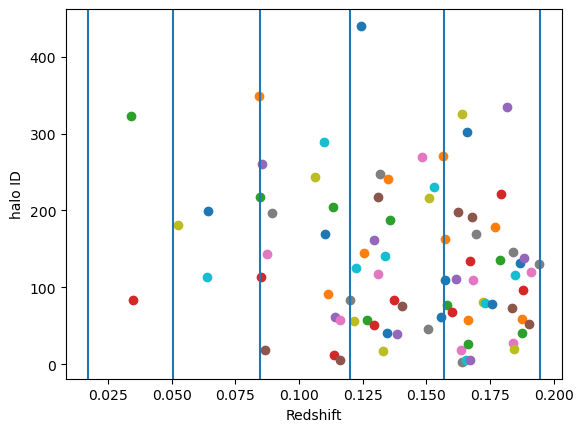

In [12]:
for cl_num in clusters.index[:]:
    #print(i, cl_num, clusters["z_true"][cl_num])
    plt.scatter(clusters["z_true"][cl_num], clusters["ihal"][cl_num])
    
for j in geometry["z_end"]:
    plt.axvline(j)
    
plt.xlabel("Redshift")
plt.ylabel("halo ID")
plt.show()

In [97]:
z1 = []
for clnum in clusters.index[:84]:
    sh = binned_clusters[clnum][1]
    #print(sh)
    if sh == '124':
        z1.append(0.174192889973847)
    elif sh == '128':
        z1.append(0.13708140389145)
    elif sh == '132':
        z1.append(0.101142861718869)
    elif sh == '136':
        z1.append(0.0663401914452304)
    elif sh == '140':
        z1.append(0.032637492755919)

#print(z1)

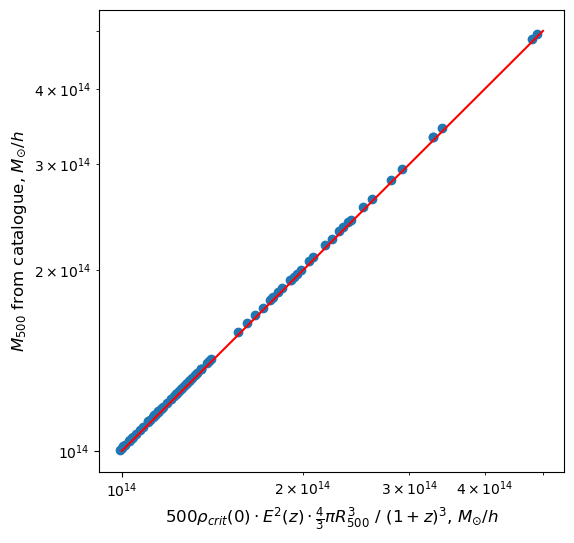

In [103]:
rho_0 = FlatLambdaCDM(H0=100*0.704, Om0=0.272).critical_density(0) # g/cm^3
rho_0 = rho_0.value / 2e33 * (3.08e21)**3
h = 0.704

r5 = clusters["R500"]/h
zs = clusters["z_true"]
zs=np.array(z1)
Es = np.sqrt(0.272*(1+zs)**3+0.728)

m5 = 4/3*np.pi * r5**3 * 500 * rho_0 * Es**2 / (1+zs)**3

plt.figure(figsize=(6,6))

plt.plot([1e14, 5e14], [1e14, 5e14], color='r')

plt.scatter(m5*h, clusters["M500"])
plt.ylabel("$M_{500}$ from catalogue, $M_{\\odot}/h$", fontsize=12)
plt.xlabel("$500 \\rho_{crit}(0) \\cdot E^2(z) \\cdot \\frac{4}{3} \\pi R_{500}^3 \\ / \\ (1+z)^3$, $M_{\\odot}/h$", fontsize=12)
plt.xscale("log")
plt.yscale("log")

#plt.xlim(1.5*10**14, 2*10**14)
#plt.ylim(1.5*10**14, 2*10**14)

#plt.savefig('M500-comparison.pdf', format='pdf', bbox_inches='tight')

plt.show()

## (A) Single cluster: image and spectra

See https://cxc.cfa.harvard.edu/ciao/ahelp/dmstat.html for centroid searching method.

#### Two panels

<Figure size 640x480 with 0 Axes>

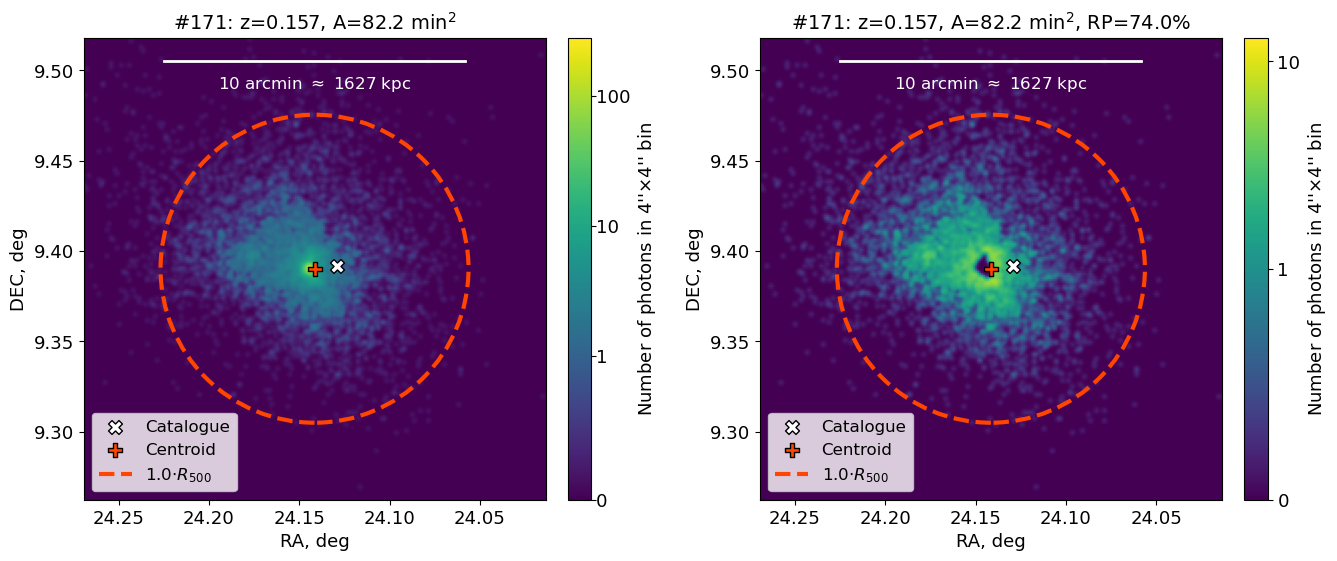

In [31]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(16,6))

cl_num = 171
RRR = 1.0

plt.subplot(121)
pho_list = extract_photons_from_cluster(cl_num, r = RRR, centroid=True, 
                                        delete_bright_regions=False, draw=True,
                                        draw_additional=False)
plt.subplot(122)
pho_list = extract_photons_from_cluster(cl_num, r = RRR, centroid=True, 
                                        delete_bright_regions=True, draw=True,
                                        draw_additional=False)
#display(pho_list)

#plt.savefig('figures/cl_ex_3.pdf', format='pdf', bbox_inches='tight')

plt.show()

In [14]:
clusters[clusters["ihal"]==46]

,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
13675,46,0.060207,0.558671,0.833035,0.005895,2.491260e+14,0.150565,0.14982,1.366470e+14,674.177,4.390640e+12,1.135250e+13,2.83882,0.578599,0.000003,2.047620e+14,1047.03,0


#### How many photons are lost because of filtering?

In [15]:
#rates_unfiltered = []
rates_filtered = []

for ci in tqdm(clusters.index[:]):
    
    create_spectrum_and_fit_it(ci, 
                               borders=[0.4, 7.0], 
                               BACKGROUND=False, 
                               inside_radius=1.0,
                               #dbr=False)
                               dbr=True)
    adr = x.AllData(1).rate
    
    #rates_unfiltered.append(adr[0])
    rates_filtered.append(adr[0])
    
#print(rates_unfiltered)

  0%|          | 0/84 [00:00<?, ?it/s]

0.7858568404086644


/tmp/ipykernel_5759/2268065038.py:8: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mappable=mapperzxs, label='Redshift $z_{true}$')


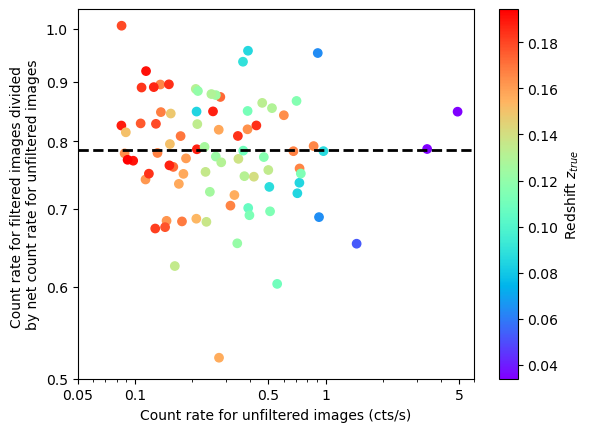

In [17]:
#plt.figure(figsize=(6,6))
fraction = np.array(rates_filtered)/np.array(rates_unfiltered)
print(np.mean(fraction))
plt.scatter(rates_unfiltered, fraction, color = zxs_colour)
plt.axhline(np.mean(fraction), ls='--', lw=2, color='black')
plt.xscale("log")
plt.yscale("log")
plt.colorbar(mappable=mapperzxs, label='Redshift $z_{true}$')
plt.xticks([0.05, 0.1, 0.5, 1, 5], [0.05, 0.1, 0.5, 1, 5])
plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0], [0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
#plt.ylim(0.4, 1)
plt.ylabel("Count rate for filtered images divided \nby net count rate for unfiltered images")
plt.xlabel("Count rate for unfiltered images (cts/s)")
plt.show()

#### Examples of spectrum

`x.Model("atable{RRCS_DB.fits}", setPars={1: current_cluster_num, 2: 1.0, 3: (D_A.value/100)**2}, sourceNum=1)
 `

,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
19787,83,0.926032,0.822913,0.526959,0.02605,3.766600e+14,0.034717,0.033992,1.682650e+14,676.952,5.699780e+12,1.686950e+13,2.84568,0.951228,0.000004,2.866160e+14,1097.25,0


<Figure size 640x480 with 0 Axes>

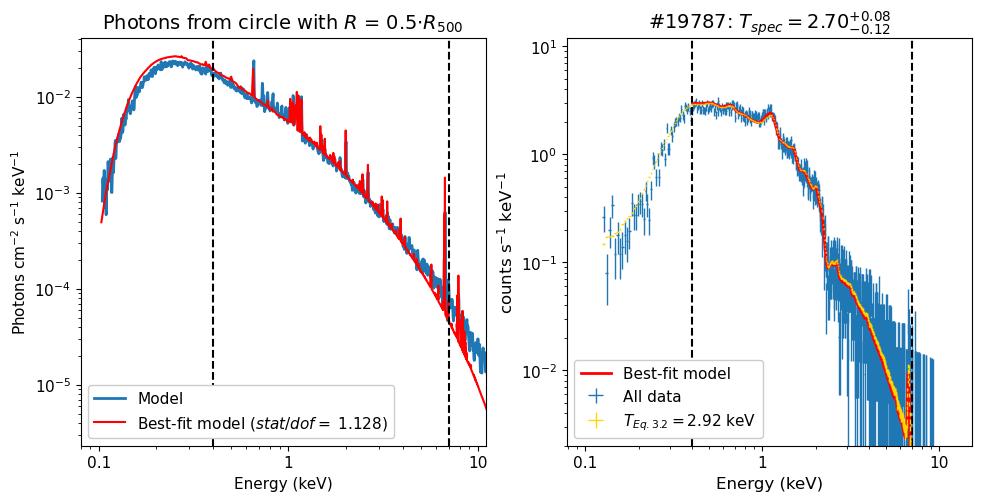

((2.7046491645865944, 2.620092905745657, 2.8201737377523513), (0.34788458169946435, 0.0, 0.0, 0.008079944232382329, 0.0, 0.0), 1.1231523768206717, 0.3)

1 file 1 spectrum 
Spectrum 1  Spectral Data File: fakeit.pha
Net count rate (cts/s) for Spectrum:1  3.231e+00 +/- 5.684e-04
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-1024
  Telescope: eROSITA Instrument: TM1  Channel Type: PI
  Exposure Time: 1e+07 sec
 Using fit statistic: cstat
 Using Response (RMF) File            ../erosita/erosita_pirmf_v20210719.rmf for Source 1
 Using Auxiliary Response (ARF) File  ../erosita/tm1_arf_open_000101v02.fits


Parameters defined:
Model phabs<1>*apec<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   phabs      nH         10^22    1.00000E-02  +/-  0.0          
   2    2   apec       kT         keV      2.91835      +/-  0.0          
   3    2   apec       Abundanc            0.300000     frozen
   4    2   apec       Redshif

(1.6526180418308676e-11, 0.0, 0.0, 0.012189175726166646, 0.0, 0.0)

In [187]:
%run -i 'utils/scripts.py'

#logFile = x.Xset.openLog("newLogFile.txt")

cl_num = 19787
RRR = 0.5

display(clusters[clusters.index==cl_num])

plt.figure(figsize=(11.5, 5.3))

SP = create_spectrum_and_fit_it(cl_num, 
                                borders=[0.4, 7.0], 
                                BACKGROUND=False, 
                                inside_radius=RRR,
                                dbr=True,
                                Xplot=False, plot=True, draw_only=False)
plt.subplot(122)
plt.ylim(2e-3, 12)

#plt.savefig('figures/obs_ex_5.pdf', format='pdf', bbox_inches='tight')

plt.show()

print(SP)

x.AllData.show()
x.AllModels.show()

x.AllModels.calcFlux(".3 2.3")
x.AllData(1).flux

In [142]:
TfE(xxx[-1])

2.9183504621041365

##### The use of the $\chi^2$ statistic for evaluating the goodness of fit. 

The data here are a series of observations of the luminosity of a star, with known error bars. Our model assumes that the brightness of the star does not vary; that is, all the scatter in the data is due to measurement error. $\chi^2_{\rm dof} \approx 1$ indicates that the model fits the data well (upper-left panel). $\chi^2_{\rm dof}$ much smaller than 1 (upper-right panel) is an indication that the errors are overestimated. $\chi^2_{\rm dof}$ much larger than 1 is an indication either that the errors are underestimated (lower-left panel) or that the model is not a good description of the data (lower-right panel). In this last case, it is clear from the data that the star’s luminosity is varying with time: this situation is be treated more fully in chapter 10. [Source](https://www.astroml.org/book_figures/chapter4/fig_chi2_eval.html)

[Kaastra (2017): On the use of C-stat in testing models for X-ray spectra](https://www.aanda.org/articles/aa/pdf/2017/09/aa29319-16.pdf)

[Dos and don’ts of reduced chi-squared](https://arxiv.org/pdf/1012.3754.pdf)

## (B)  Draw all 84 clusters

### Images:

In [10]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

draw_84_panels(mode='IMAGE')

plt.savefig('panels_unfiltered.png', format='png', dpi=200, bbox_inches='tight')
plt.close()
#plt.show()

  0%|          | 0/84 [00:00<?, ?it/s]

### (B0) Create `atable` for `xspec` with all 84 clusters

https://github.com/mbursa/xspec-table-models

`from xspec_table_models import XspecTableModelAdditive`

In [ ]:
%run -i 'utils/xspec_table_models.py'
%run -i 'utils/scripts.py'

radii = [0.15, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5]  # in units of projected R_500

def atablemodel_input(CL_NUM, RADIUS):
    
    #plt.figure(figsize=(11,5))
    pho_list = extract_photons_from_cluster(CL_NUM, r = RADIUS, draw=False, delete_bright_regions=True)
    
    #create_spectrum_and_fit_it(CL_NUM, borders=[0.4, 7.0], BACKGROUND=False, inside_radius=RADIUS,
    #                            Xplot=False, plot=True, draw_only=False)
    #plt.show()
    
    photons1, energies_bins1 = np.histogram(pho_list["ENERGY"], bins = binning1)

    # specific fluxes [erg/s/cm2/keV] for the grid of energies1
    spec_flux = [a*b*(1.6*10**(-9))/10000/1000/c for a, b, c in zip(photons1, energies1, dE1)]
    
    return [ sf * scale_by_distance(CL_NUM) for sf in spec_flux]

def scale_by_distance(CL_NUM): # normalization at 100 Mpc (z~0.024)
    
    D_A = FlatLambdaCDM(H0=100*0.704, Om0=0.272).angular_diameter_distance(clusters.loc[CL_NUM]["z_true"]) # Mpc
    
    return (D_A.value/100)**2

N_channels1 = 4096
binning1 = np.logspace(np.log10(0.1), np.log10(12.0), N_channels1+1)
energies1 = [(a+b)/2 for a, b in zip(binning1[:-1], binning1[1:])]
dE1 = np.diff(binning1)

par1 = ('Number', list(clusters.index[:].values), False, True)
par2 = ('Radius', radii, False, True)

feets = XspecTableModelAdditive('RRCS_DB.fits', 'atableModel', np.array(energies1), [par1, par2], False)

index = 0
for cl_num in tqdm(par1[1]):
    for radius in tqdm(par2[1]):
        print(index, [cl_num, radius])
#for g in feets.generator():
#    index, param_values, param_indexes, energies = g
#    print(param_values)
        Iv = atablemodel_input(cl_num, radius)     # get the spectrum
        feets.write(index, Iv, False)    # write to FITS file
        index = index + 1

feets.save()

### (B1)  Fit  and draw all 84 clusters' spectra, with or without background

Considering: abundance = 0.3, cstat, exposure = 10000 s, weights = standard 

In [ ]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

draw_84_panels(mode='DATA')

plt.savefig('observations_84.png', format='png', dpi=200, bbox_inches='tight')
plt.show()

### (B2)  Fit and draw all 84 clusters' models (original and fitted), with or without background

In [ ]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

draw_84_panels(mode='MODEL')

plt.savefig('model_84.png', format='png', dpi=200, bbox_inches='tight')
plt.show()

## (C) Averaging (no background)

Check that abundance is FIXED (at 0.3 Solar) here:

In [ ]:
%run -i 'utils/scripts.py'

table_name = '0_clean_50_1ks'

calculate_all_and_average_it(BACKGROUND=False, write_to_file=table_name)

### Abundance check (if free):

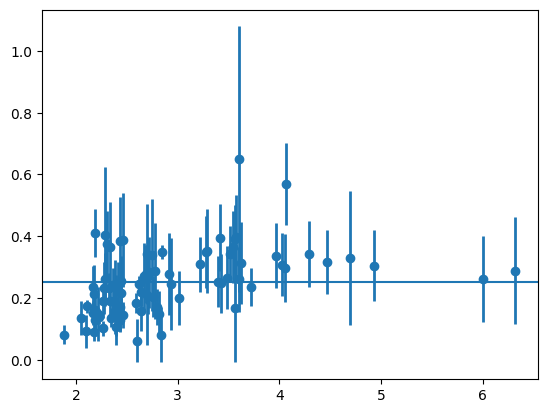

In [78]:
plt.errorbar(read_table[1].values(), read_table[9].values(), 
             yerr=list(read_table[10].values()), lw=0, elinewidth=2, marker=".")

plt.axhline(np.mean(list(read_table[9].values())))

In [80]:
np.mean(list(read_table[9].values()))

0.25194364886456394

### Reading from table:

In [131]:
NNNN = 50

table_name =  '0_clean_50_1.0' # new_new #_0.5-2.0'

read_table = pd.read_csv('tables/table_'+table_name+'.csv', header=None, index_col=0, delimiter=' ').to_dict()
    
temp_usr =  list(zip(read_table[1].values(), read_table[2].values(), read_table[3].values()))
lumin_usr = list(zip(read_table[4].values(), read_table[5].values(), read_table[6].values()))
aven_usr =  list(zip(read_table[7].values(), read_table[8].values()))

### Lower exsposures:

In [24]:
NNNN = 50

#table_name = '0_ab-fix_cstat_10ks_standard-'+str(NNNN)
table_name = '0_clean_50_lowexp'

read_table = pd.read_csv('tables/table_'+table_name+'.csv', header=None, index_col=0, delimiter=' ').to_dict()
    
temp_usr_lowexp =  list(zip(read_table[1].values(), read_table[2].values(), read_table[3].values()))
lumin_usr_lowexp = list(zip(read_table[4].values(), read_table[5].values(), read_table[6].values()))
aven_usr_lowexp =  list(zip(read_table[7].values(), read_table[8].values()))

In [25]:
NNNN = 50

#table_name = '0_ab-fix_cstat_10ks_standard-'+str(NNNN)
table_name =  '0_clean_50_midexp'

read_table = pd.read_csv('tables/table_'+table_name+'.csv', header=None, index_col=0, delimiter=' ').to_dict()
    
temp_usr_midexp =  list(zip(read_table[1].values(), read_table[2].values(), read_table[3].values()))
lumin_usr_midexp = list(zip(read_table[4].values(), read_table[5].values(), read_table[6].values()))
aven_usr_midexp =  list(zip(read_table[7].values(), read_table[8].values()))

In [50]:
NNNN = 50

#table_name = '0_ab-fix_cstat_10ks_standard-'+str(NNNN)
table_name =  '0_clean_50_2ksexp'

read_table = pd.read_csv('tables/table_'+table_name+'.csv', header=None, index_col=0, delimiter=' ').to_dict()
    
temp_usr_2ksexp =  list(zip(read_table[1].values(), read_table[2].values(), read_table[3].values()))
lumin_usr_2ksexp = list(zip(read_table[4].values(), read_table[5].values(), read_table[6].values()))
aven_usr_2ksexp =  list(zip(read_table[7].values(), read_table[8].values()))

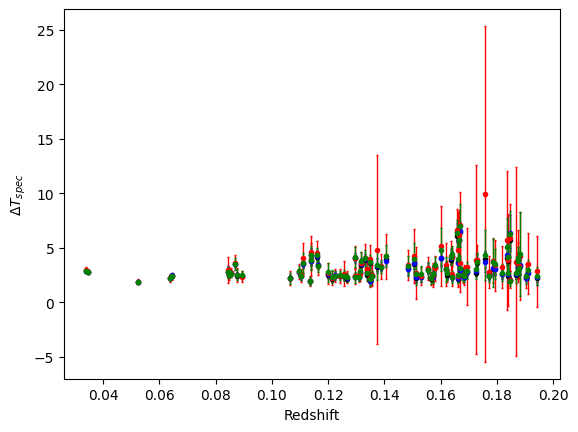

In [52]:
#plt.plot(redshifts, [a[2] for a in temp_usr], 'o', markersize=2, color='black')
plt.errorbar(redshifts, [a[1] for a in temp_usr], 
             yerr=[a[2] for a in temp_usr], lw=0, elinewidth=1, capsize=1, color='black', marker=".")

plt.errorbar(redshifts, [a[1] for a in temp_usr_midexp], 
             yerr=[a[2] for a in temp_usr_midexp], lw=0, elinewidth=1, capsize=1, color='blue', marker=".")

plt.errorbar(redshifts, [a[1] for a in temp_usr_lowexp], 
             yerr=[a[2] for a in temp_usr_lowexp], lw=0, elinewidth=1, capsize=1, color='red', marker=".")

plt.errorbar(redshifts, [a[1] for a in temp_usr_2ksexp], 
             yerr=[a[2] for a in temp_usr_2ksexp], lw=0, elinewidth=1, capsize=1, color='green', marker=".")

plt.xlabel("Redshift")
plt.ylabel("$\Delta T_{spec}$")
plt.show()

### (C0) Spectral temperature compared to $T_{500}$

<Figure size 640x480 with 0 Axes>

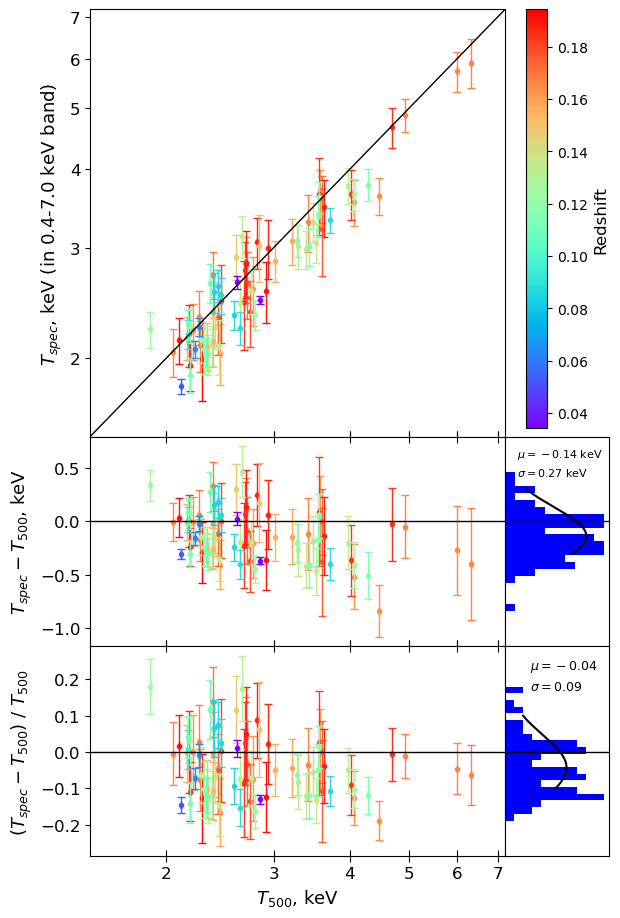

In [49]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

t500s = list(zip(np.zeros(len(temp_usr)), [a[0] for a in temp_usr], np.zeros(len(temp_usr))))

draw_three_panels_vertical(x_array=t500s,
                  y_array=temp_usr,
                  x_label="$T_{500}$, keV",
                  y_label_left="$T_{spec}$, keV (in 0.4-7.0 keV band)",
                  y_label_right_up="$T_{spec} - T_{500}$, keV",
                  y_label_right_down="$(T_{spec} - T_{500}) \\ / \\ T_{500}$",
                  clr='b',
                  NnNn=NNNN,
                  cmap=redshifts,
                  cmap_label="Redshift")

#plt.savefig('figures/T_vs_T500_vertical.pdf', format='pdf', bbox_inches='tight')
plt.show()

2471, 6695

### Comparison of temperatures with Chandra

In [22]:
NNNN = 50

#table_name = '0_ab-fix_cstat_10ks_standard-'+str(NNNN)
table_name =  '0_clean_50_Chandra' # new_new #_0.5-2.0'

read_table = pd.read_csv('tables/table_'+table_name+'.csv', header=None, index_col=0, delimiter=' ').to_dict()
    
temp_usr_ch =  list(zip(read_table[1].values(), read_table[2].values(), read_table[3].values()))
lumin_usr_ch = list(zip(read_table[4].values(), read_table[5].values(), read_table[6].values()))
aven_usr_ch =  list(zip(read_table[7].values(), read_table[8].values()))

<Figure size 640x480 with 0 Axes>

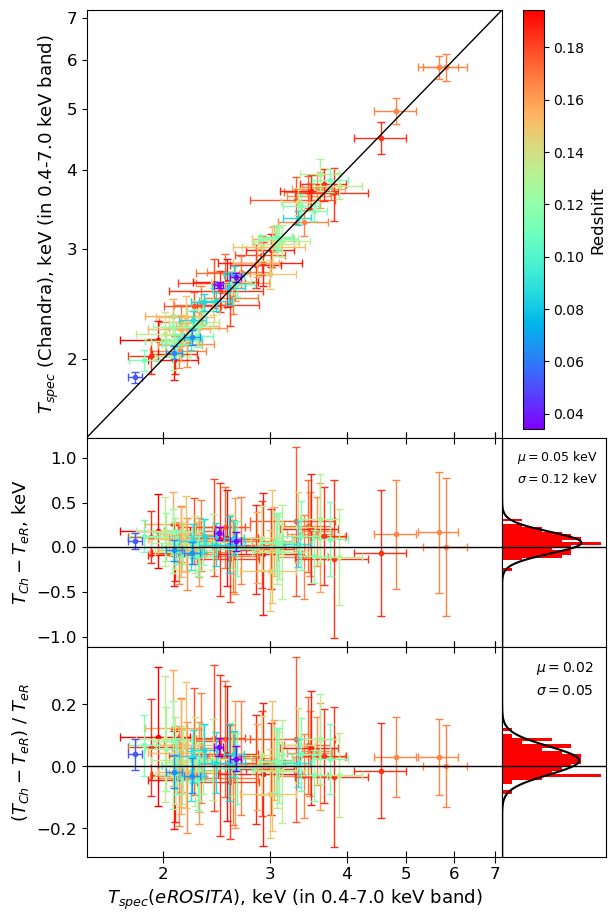

In [25]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

t500s = list(zip(np.zeros(len(temp_usr)), [a[0] for a in temp_usr], np.zeros(len(temp_usr))))

draw_three_panels_vertical(x_array=temp_usr,
                  y_array=temp_usr_ch,
                  x_label="$T_{spec} (eROSITA)$, keV (in 0.4-7.0 keV band)",
                  y_label_left="$T_{spec}$ (Chandra), keV (in 0.4-7.0 keV band)",
                  y_label_right_up="$T_{Ch} - T_{eR}$, keV",
                  y_label_right_down="$(T_{Ch} - T_{eR}) \\ / \\ T_{eR}$",
                  clr='r',
                  NnNn=NNNN,
                  cmap=redshifts,
                  cmap_label="Redshift")

plt.savefig('T_vs_T500_ch.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Comparison of temperatures from within $1.0 \cdot R_{500}$ and $0.5 \cdot R_{500}$

In [130]:
NNNN = 50

#table_name = '0_ab-fix_cstat_10ks_standard-'+str(NNNN)
table_name =  '0_clean_50_0.5' # new_new #_0.5-2.0'

read_table = pd.read_csv('tables/table_'+table_name+'.csv', header=None, index_col=0, delimiter=' ').to_dict()
    
temp_usr_half =  list(zip(read_table[1].values(), read_table[2].values(), read_table[3].values()))
lumin_usr_half = list(zip(read_table[4].values(), read_table[5].values(), read_table[6].values()))
aven_usr_half =  list(zip(read_table[7].values(), read_table[8].values()))

<Figure size 640x480 with 0 Axes>

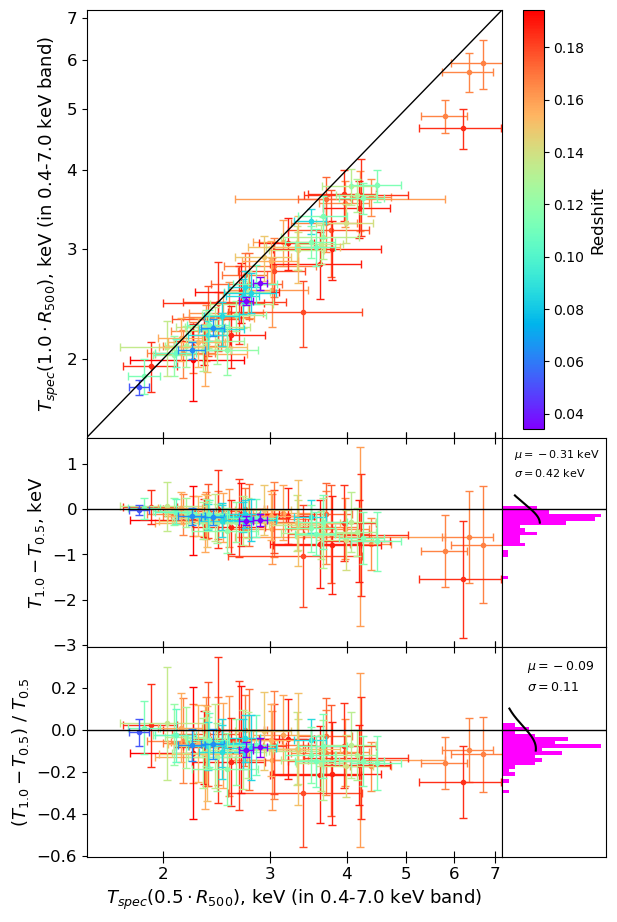

In [73]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

t500s = list(zip(np.zeros(len(temp_usr)), [a[0] for a in temp_usr], np.zeros(len(temp_usr))))

draw_three_panels_vertical(x_array=temp_usr_half,
                  y_array=temp_usr,
                  x_label="$T_{spec} (0.5 \\cdot R_{500})$, keV (in 0.4-7.0 keV band)",
                  y_label_left="$T_{spec} (1.0 \\cdot R_{500})$, keV (in 0.4-7.0 keV band)",
                  y_label_right_up="$T_{1.0} - T_{0.5}$, keV",
                  y_label_right_down="$(T_{1.0} - T_{0.5}) \\ / \\ T_{0.5}$",
                  clr='magenta',
                  NnNn=NNNN,
                  cmap=redshifts,
                  cmap_label="Redshift")

#plt.savefig('T_vs_T500_half.pdf', format='pdf', bbox_inches='tight')
plt.show()

### (C1) Temperature and luminosity from fit as a functions of $T_{500}$ and $L_{500}$ from several fits.

<Figure size 640x480 with 0 Axes>

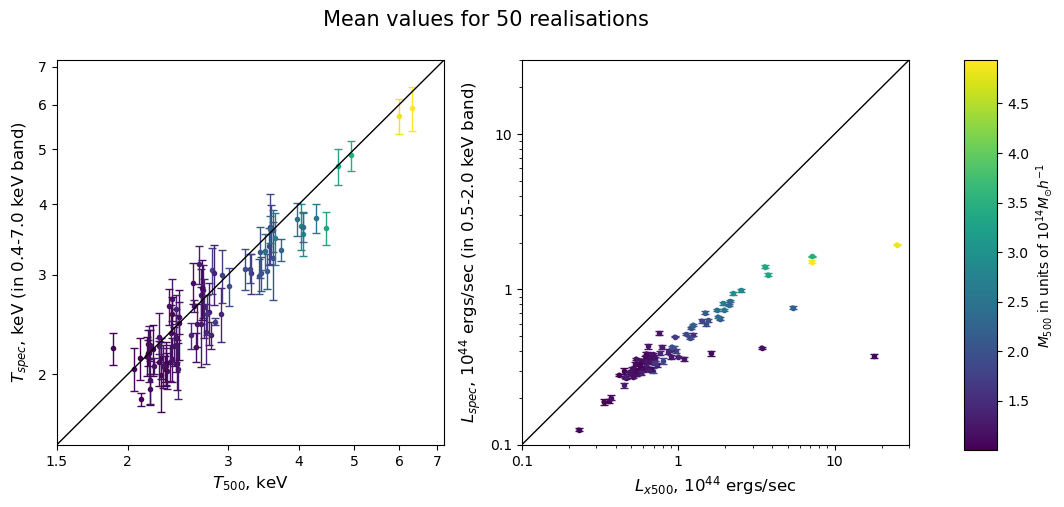

In [50]:
%run -i 'utils/functions.py'

plt.figure(figsize=(11,5))

plt.suptitle(f"     Mean values for {NNNN} realisations", fontsize=15)

plt.subplot(121)

xx = [a[0] for a in temp_usr]
yy = [a[1] for a in temp_usr]
y_err = [a[2] for a in temp_usr]

#plt.errorbar(xx, yy, yerr=[yerr_l, yerr_r], linewidth=0, elinewidth=1, color='b', marker='o', markersize=3)

for xxx, yyy, eee, col in zip(xx, yy, y_err, mass_colour):
    plt.plot(xxx, yyy, '.', color=col)
    plt.errorbar(xxx, yyy, yerr=eee, elinewidth=1, capsize=3, color=col)

plt.xlabel("$T_{500}$, keV", fontsize=12)
plt.ylabel("$T_{spec}$, keV (in 0.4-7.0 keV band)", fontsize=12)

plt.xlim(1.5, 7.2)
plt.ylim(1.5, 7.2)

plt.xscale("log")
plt.yscale("log")

plt.xticks([plt.gca().get_xlim()[0],2,3,4,5,6,7], [plt.gca().get_xlim()[0],2,3,4,5,6,7])
plt.yticks([2,3,4,5,6,7], [2,3,4,5,6,7])

plt.plot([min(plt.gca().get_xlim()), max(plt.gca().get_xlim())],
         [min(plt.gca().get_ylim()), max(plt.gca().get_ylim())], color='black', linewidth=1)

#plt.scatter(2.60178, 3.985203132730008, color='red')

plt.subplot(122)

xx = [a[0] for a in lumin_usr]
#xx = [a[0]/(2*m**0.3) for a, m in zip(lumin_usr, masses)] # correction (see pictures) when converting from 0.5-2.0 to 0.1-10
yy = np.array([a[1] for a in lumin_usr]) /np.array([E(rr) for rr in redshifts]) #*(np.ones(len(redshifts))+redshifts)**2
y_err = [a[2] for a in lumin_usr]#*np.array([E(rr) for rr in redshifts]) #*(np.ones(len(redshifts))+redshifts)**2

#plt.errorbar(xx, yy, yerr=[yerr_l, yerr_r], linewidth=0, elinewidth=1, color='b', marker='o', markersize=3)

for xxx, yyy, eee, col in zip(xx, yy, y_err, mass_colour):
    plt.plot(xxx, yyy, '.', color=col)
    plt.errorbar(xxx, yyy, yerr=eee, elinewidth=1, capsize=3, color=col)

plt.xlabel("$L_{x500}$, $10^{44}$ ergs/sec", fontsize=12)
plt.ylabel("$L_{spec}$, $10^{44}$ ergs/sec (in 0.5-2.0 keV band)", fontsize=12)

plt.xscale("log")
plt.yscale("log")

plt.xlim(0.15, 30)
plt.ylim(0.15, 30)

plt.xticks([0.1, 1, 10], [0.1, 1, 10])
plt.yticks([0.1, 1, 10], [0.1, 1, 10])

#plt.axvline(0.592084)
#plt.axhline(0.2546419982104965)

plt.plot([min(plt.gca().get_xlim()), max(plt.gca().get_xlim())],
         [min(plt.gca().get_ylim()), max(plt.gca().get_ylim())], color='black', linewidth=1)

plt.subplots_adjust(right=0.9)
sc = plt.scatter(xx, yy, c=masses, s=5)
clb = plt.colorbar(sc, cax = plt.axes([0.95, 0.1, 0.03, 0.78]), 
                   label = "$M_{500}$ in units of $10^{14} M_{\\odot} h^{-1}$")

#plt.savefig('figures/T_vs_T_and_L_vs_L.pdf', format='pdf')

plt.show()

#L-T, L-M, T-M

Note how small are errors for luminosities!

### (C2) Average energy as a function of **mean** temperature

##### aven_usr: [ $E_{av}, \Delta E$ ], temp_usr: [ $T_{sim}, T_{spec}, \Delta T$ ]

[How to get confidence intervals from curve_fit](https://stackoverflow.com/questions/39434402/how-to-get-confidence-intervals-from-curve-fit)

[Correct fitting with scipy curve_fit including errors in x?](https://stackoverflow.com/questions/26058792/correct-fitting-with-scipy-curve-fit-including-errors-in-x)

[How to plot 1-Sigma Prediction Interval for scipy.odr](https://stackoverflow.com/questions/60889680/how-to-plot-1-sigma-prediction-interval-for-scipy-odr)

[Confidence interval for exponential curve fit](https://stackoverflow.com/questions/24633664/confidence-interval-for-exponential-curve-fit/37080916#37080916)

In [68]:
clusters

,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
171,110,0.970969,0.479718,0.014316,0.004703,2.432930e+14,0.157249,0.157891,1.366960e+14,688.128,4.470500e+12,1.209540e+13,2.44633,0.707698,0.000003,2.049620e+14,1068.920,0
187,163,0.388924,0.570999,0.016006,0.004675,2.390080e+14,0.157312,0.159659,1.126680e+14,645.187,2.896080e+12,1.061830e+13,2.43074,0.532571,0.000003,2.049290e+14,1068.880,0
350,77,0.380183,0.570491,0.033800,0.005197,3.282700e+14,0.157977,0.157810,1.925340e+14,771.351,5.156740e+12,2.121000e+13,3.21771,1.515690,0.000005,2.887220e+14,1198.270,0
820,68,0.735543,0.863489,0.086085,0.005228,3.341870e+14,0.159935,0.160192,1.800240e+14,754.271,6.340420e+12,1.596800e+13,3.57076,0.972861,0.000004,2.724390e+14,1175.290,0
1245,111,0.804864,0.355207,0.133510,0.004668,2.379170e+14,0.161713,0.161111,1.321030e+14,680.349,4.667490e+12,9.869480e+12,2.78095,0.452088,0.000003,1.944720e+14,1050.360,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18589,113,0.839159,0.495644,0.394607,0.011199,2.242680e+14,0.063945,0.063977,1.184480e+14,615.838,2.883010e+12,1.160680e+13,2.22808,0.537683,0.000002,1.889120e+14,976.536,0
18610,199,0.149218,0.307198,0.406194,0.011455,2.400200e+14,0.064342,0.064928,1.282700e+14,632.408,3.427130e+12,1.130680e+13,2.26553,0.455429,0.000002,1.935300e+14,984.440,0
19523,349,0.373303,0.943536,0.987909,0.010375,1.783400e+14,0.084342,0.084015,1.055570e+14,592.650,3.313370e+12,6.942770e+12,2.39539,0.231120,0.000002,1.464050e+14,897.005,0
19771,323,0.759637,0.387809,0.508332,0.020783,1.912580e+14,0.034099,0.033707,1.272360e+14,616.706,3.593030e+12,1.067760e+13,2.61661,0.651073,0.000003,1.638830e+14,910.698,0


<Figure size 640x480 with 0 Axes>

Beta: [1.5094648  6.67866763]
Beta Std Error: [0.036067  0.2281373]
Beta Covariance: [[ 0.00092792 -0.005447  ]
 [-0.005447    0.0371264 ]]
Residual Variance: 1.4018765037952365
Inverse Condition #: 0.05385222312592452
Reason(s) for Halting:
  Sum of squares convergence
0.0846463258998017 0.012783681283603663


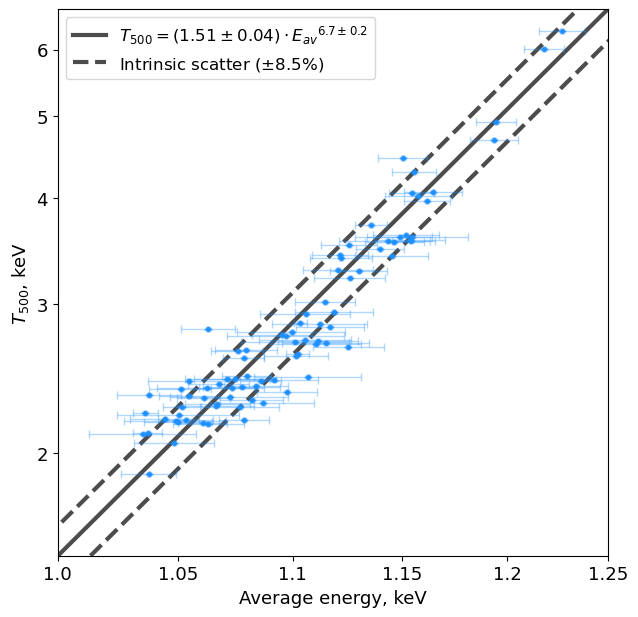

In [153]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

plt.figure(figsize=(7.1,7.1))

xx = [a[0] for a in aven_usr]
x_err = [a[1] for a in aven_usr]
yy1 = [a[0] for a in temp_usr]
yy2 = [a[1] for a in temp_usr]
y2_err = [a[2] for a in temp_usr]

lll = np.linspace(0.9, 1.5, 100)        

#draw_line(xx, x_err, yy2, y_es=y2_err, 
#          clr = 'blue', 
#          l4dots = '$T_{spec}$ from fit', 
#          l4legend = 'T_{{spec}}',
#          argument='E_{{av}}',
#          with_intervals = True,
#          with_scatter=True)

draw_line(xx, np.array(x_err), yy1, y_es=np.array(yy1)*0, 
          clr = 'dodgerblue', 
          l4dots = '$T_{500}$ from simulations', 
          l4legend = 'T_{{500}}',
          argument='E_{{av}}',
          with_scatter=True)        
        
plt.xlabel("Average energy, keV", fontsize=13)
plt.ylabel("$T_{500}$, keV", fontsize=13)

plt.xscale("log")
plt.yscale("log")

Xtix = [1.00, 1.05, 1.10, 1.15, 1.2, 1.25]
Ytix = [2,3,4,5,6]

plt.ylim(1.51, 6.7)
plt.xlim(1.0, 1.25)

plt.xticks(Xtix, Xtix, size=13)
plt.yticks(Ytix, Ytix, size=13)

#for i in range(0, len(aven_usr)):
#    plt.plot([xx[i]+0.000454, xx[i]+0.000454], 
#             [yy1[i], yy2[i]], 
#             color='grey', alpha=0.4, marker='o', markersize=4)

#plt.grid()

plt.legend(loc=2, fontsize = 12)

ooofff = (plt.gca().get_xlim(), plt.gca().get_ylim())

#plt.savefig('figures/T_vs_Eav-NEW.pdf', format='pdf', bbox_inches='tight')
plt.show()

#yy234 = yy1-1.36*np.array(xx)**6.8
#xx234 = xx

#plt.figure(figsize=(7, 4))
#plt.scatter(xx, yy1)
#plt.xscale("log")
#plt.yscale("log")
#plt.xticks(Xtix, Xtix, size=13)
#plt.scatter(xx, xx11)
#plt.axhline(0, color='red', ls='--')
#plt.show()

In [152]:
#%run -i 'utils/draw.py'
#calculate_scatter(xx, yy2, plot=True)

### (C3) Testing `apec` models vs our data

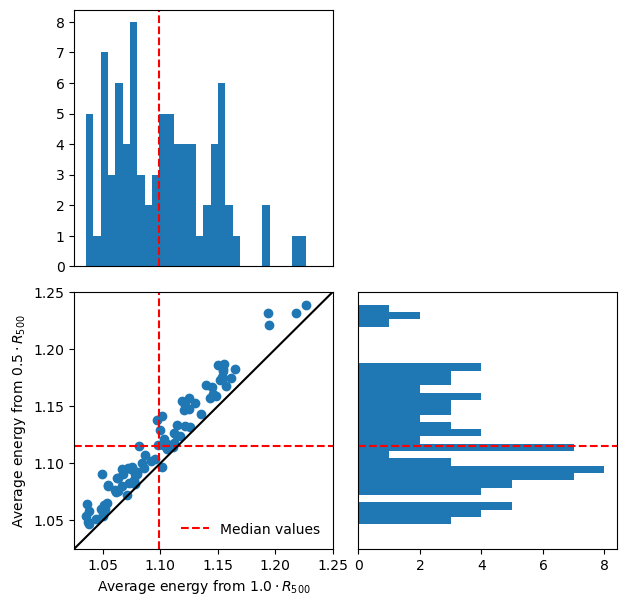

In [137]:
plt.figure(figsize = (7,7))

plt.subplot(221)
plt.hist([b[0] for b in aven_usr], bins=30, histtype='stepfilled')
plt.xticks([])
plt.axvline(np.median([b[0] for b in aven_usr]), linestyle='--', color='red')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
#plt.yticks([0,5,10,15,20], [0,5,10,15,20])
plt.xlim(1.025, 1.25)

plt.subplot(224)
plt.hist([b[0] for b in aven_usr_half], bins=30, histtype='stepfilled', orientation="horizontal")
#plt.xlabel("Redshift $z_{true}$")
plt.yticks([])
plt.axhline(np.median([b[0] for b in aven_usr_half]), linestyle='--', color='red')
plt.ylim(1.025, 1.25)

#plt.show()

#plt.figure(figsize = (5,5))

plt.subplot(223)

plt.scatter([b[0] for b in aven_usr], [b[0] for b in aven_usr_half])

plt.ylabel("Average energy from $0.5 \\cdot R_{500}$")
plt.xlabel("Average energy from $1.0 \\cdot R_{500}$")
#plt.xscale("log")
#plt.xticks([1,2,3,4,5], [1,2,3,4,5])
#plt.yscale("log")
plt.axvline(np.median([b[0] for b in aven_usr]), linestyle='--', color='red')
plt.axhline(np.median([b[0] for b in aven_usr_half]), linestyle='--', color='red', label="Median values")
plt.plot([1.025, 1.25], [1.025, 1.25], color='k')
plt.ylim(1.025, 1.25)
plt.xlim(1.025, 1.25)
plt.legend(frameon=False)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

#plt.savefig('figures/histogram_84.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [177]:
plt.figure(figsize=(7.1,7.1))

xxx = [a[0] for a in aven_usr]
xxx_err = [a[1] for a in aven_usr]

yyy0 = [a[0] for a in temp_usr]
#yyy = [a[1] for a in temp_usr]
#yyy_err = [a[2] for a in temp_usr]
#lll = np.linspace(1.04, 1.24, 100) 

def TfE(eav):
    return 1.51*eav**6.7

temps7 = [TfE(EAV) for EAV in xxx]           # better consistency
avens7 = np.zeros(84)
redshifts7 = zxs

x.Plot.device = "/null"

for i in tqdm(range(84)):
    
    x.Xset.chatter = 0
    x.Model("phabs*apec", setPars={1:0.01, 2:temps7[i], 3:0.3, 4:0, 5:1})
    #x.Plot("model")
    
    x.AllData.clear()
    fs = x.FakeitSettings(response = '../erosita/erosita_pirmf_v20210719.rmf', 
                               arf = '../erosita/tm1_arf_open_000101v02.fits', 
                        background = '', 
                          exposure = 10000, 
                        correction = '', 
                      backExposure = '', 
                          fileName = 'fakeit.pha')
    x.AllData.fakeit(nSpectra = 1, 
                     settings = fs, 
                   applyStats = True,
                   filePrefix = "",
                      noWrite = False)

    x.AllData.ignore(f"**-{0.4} {7.0}-**")
    x.Plot.xAxis = "keV"
    x.Plot("data")

    s_i = x.AllData(1).values
    ens = x.AllData(1).energies
    E_i = [(e[0]+e[1])/2 for e in ens]
    av_en = np.dot(E_i, s_i)/np.sum(s_i)    
    
    x.Xset.chatter = 10
    
    avens7[i] = av_en

  0%|          | 0/84 [00:00<?, ?it/s]

<Figure size 710x710 with 0 Axes>

In [178]:
#avens_half = avens7

In [179]:
#AVENS = xxx

<Figure size 640x480 with 0 Axes>

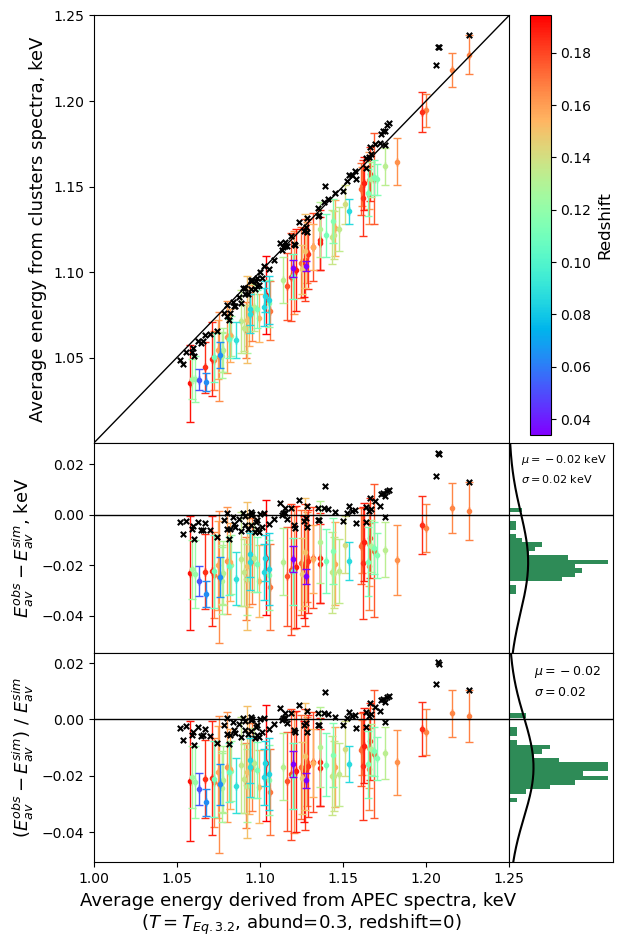

In [180]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

#list(zip(np.zeros(len(temp_usr)), [a[0] for a in aven_usr_half], [a[1] for a in aven_usr_half]))

noolee = np.zeros(len(temp_usr))

draw_three_panels_vertical(x_array=list(zip(noolee, avens7, np.zeros(len(avens7)))), 
                  y_array=list(zip(noolee, xxx, xxx_err)),
                  x_label="Average energy derived from APEC spectra, keV \n($T=T_{Eq. 3.2}$, abund=0.3, redshift=0)",
                  y_label_left="Average energy from clusters spectra, keV",
                  y_label_right_up="$E_{av}^{obs} - E_{av}^{sim}$, keV",
                  y_label_right_down="$(E_{av}^{obs} - E_{av}^{sim}) \\ / \\ E_{av}^{sim}$",
                  clr='seagreen',
                  NnNn = NNNN,
                  cmap = redshifts,
                  cmap_label="Redshift")

#ax1.scatter(avens7, [a[0] for a in aven_usr_half], 'o', color='k', markersize=3)

#plt.savefig('figures/Eav_vs_Eav_vertical.pdf', format='pdf', bbox_inches='tight')

#plt.savefig('APEC-1.0_R500.pdf', format='pdf', bbox_inches='tight')

plt.show()

## (G) Adding background

[ABSOLUTE MEASUREMENT OF THE UNRESOLVED COSMIC X-RAY BACKGROUND
IN THE 0.5–8 KEV BAND WITH CHANDRA](https://arxiv.org/pdf/astro-ph/0512542.pdf)

[CHANDRA SPECTRA OF THE SOFT X-RAY DIFFUSE BACKGROUND](https://iopscience.iop.org/article/10.1086/345347/pdf)

`'5_ab-fix_cstat_10ks_standard_BKG-50_with_area'`

In [ ]:
%run -i 'utils/scripts.py'

NNNN = 10

calculate_all_and_average_it(BACKGROUND=True, write_to_file='5_with_bkg_10')

In [ ]:
%run -i 'utils/scripts.py'

pop = average_one_cluster(6496, N_usr=50, bkg=True)

6496 3.56059 4.513200861103114 1.3203285056576024 0.800871 0.3556095533149401 0.029025380001200175 1.153315195648787 0.05911742125435248 75.30404403516658 83.49807701318436 10.246047573296856 0.000711494524313075 5.2049041546314914e-05

#### Concatenate 5 lists with averaging by 10 realisations each:

In [23]:
all_files = pd.DataFrame()

for tn in [1,3,4,5]:
    
    table_name = '5_with_bkg_10_'+str(tn)

    file1 = pd.read_csv('tables/table_'+table_name+'.csv', header=None, index_col=0, delimiter=' ')

    #display(file1)
    all_files = pd.concat([all_files, file1])

#display(all_files)

result = {}

for i in range(84):
    
    #display(all_files[i::84])
    
    #print(all_files[i::84].mean())
    
    result[clusters.index[i]] = all_files[i::84].mean()

    #display(pd.DataFrame(result[clusters.index[i]]).T)
result_df = pd.DataFrame(result).T

write_to_file = '5_with_bkg_50'

result_df.to_csv('tables/table_'+write_to_file+'.csv', sep=' ', header=False, index=True)

#### Reading from table:

In [75]:
NNNN = 10

#table_name = '5_ab-fix_cstat_10ks_standard_BKG-'+str(NNNN)+'_z=0'
#table_name =  '5_with_bkg_50_new-reserve'
#table_name =  '5_with_bkg_50_new-after-filtering'
#table_name =  '5_with_bkg_50_new-exp10000ks'
table_name =  '5_with_bkg_50'

read_table = pd.read_csv('tables/table_'+table_name+'.csv', header=None, index_col=0, delimiter=' ').to_dict()
    
temp_usr_with_bkg =  list(zip(read_table[1].values(), read_table[2].values(), read_table[3].values()))
lumin_usr_with_bkg = list(zip(read_table[4].values(), read_table[5].values(), read_table[6].values()))
aven_usr_with_bkg =  list(zip(read_table[7].values(), read_table[8].values()))

How do the errors correlate with the redshift?

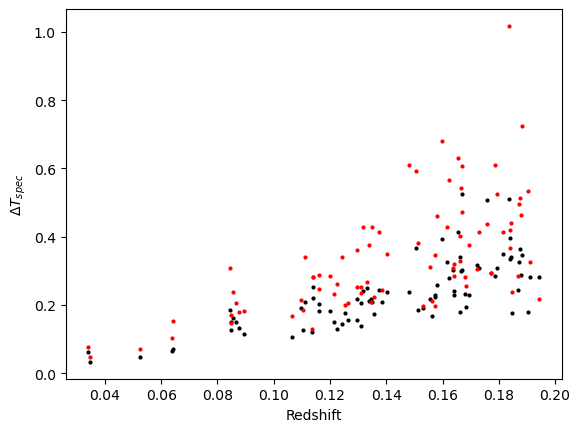

In [160]:
plt.plot(redshifts, [a[2] for a in temp_usr], 'o', markersize=2, color='black')
plt.plot(redshifts, [a[2] for a in temp_usr_with_bkg], 'o', markersize=2, color='red')
#plt.errorbar(redshifts, [a[1] for a in temp_usr], 
#             yerr=[a[2] for a in temp_usr], lw=0, elinewidth=1, capsize=1, color='black')
plt.xlabel("Redshift")
plt.ylabel("$\\Delta T_{spec}$")
#plt.xscale("log")
#plt.yscale("log")
plt.show()

#### Experiments with constant before background:

In [26]:
display(pd.DataFrame(read_table))

,1,2,3,4,5,6,7,8,9,10,11,12,13
171,2.44633,1.727436,0.197748,0.707698,0.353883,0.020921,1.072578,0.039127,84.633494,98.138334,12.107592,0.000865,0.000078
187,2.43074,2.451162,0.347285,0.532571,0.324149,0.021409,1.069193,0.043825,74.342699,90.844580,10.212143,0.000853,0.000059
350,3.21771,3.196034,0.461127,1.515690,0.623028,0.025367,1.133419,0.031692,105.398246,111.641355,11.982186,0.001668,0.000065
820,3.57076,3.540936,0.680612,0.972861,0.434449,0.020086,1.144286,0.036351,98.417169,95.845500,9.609561,0.001143,0.000044
1245,2.78095,2.560399,0.429650,0.452088,0.260483,0.021851,1.088293,0.056389,78.383429,76.840828,8.736247,0.000649,0.000055
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18589,2.22808,2.005033,0.103770,0.537683,0.309960,0.008803,1.033512,0.013766,393.511717,548.857914,28.562915,0.005328,0.000178
18610,2.26553,2.231820,0.154742,0.455429,0.251989,0.006093,1.050197,0.020961,409.940945,497.999512,18.558266,0.004340,0.000117
19523,2.39539,2.544552,0.309811,0.231120,0.118206,0.007400,1.094241,0.060365,211.320646,238.441763,14.272253,0.001172,0.000074
19771,2.61661,2.546058,0.078467,0.651073,0.303040,0.004145,1.103668,0.008623,1370.408136,1432.667774,46.814894,0.019522,0.000270


In [27]:
area_usr_with_bkg = list(zip(read_table[9].values(), read_table[10].values(), read_table[11].values()))
norm_usr_with_bkg = list(zip(read_table[12].values(), read_table[13].values()))
#pbkg_usr_with_bkg = list(zip(read_table[14].values(), read_table[15].values(), read_table[16].values()))

ORIGA = np.array([n[0] for n in area_usr_with_bkg])
SPECA = np.array([n[1] for n in area_usr_with_bkg])
SPECA_delta = np.array([n[2] for n in area_usr_with_bkg])

NORM = np.array([n[0] for n in norm_usr_with_bkg])
NORM_delta = np.array([n[1] for n in norm_usr_with_bkg])

SKOLKO1 = SPECA/ORIGA
SKOLKO1_delta = SPECA_delta/ORIGA

print(SKOLKO1)

[1.1595685  1.22197043 1.05923351 0.9738697  0.98031981 1.16069409
 0.84713136 1.01358636 1.25112371 1.05023903 1.25922315 0.91146949
 1.08599479 0.97109545 0.91862999 1.12636764 1.17667525 1.30017607
 1.0786089  1.16667168 0.91867867 1.01346437 1.04202517 1.0329793
 0.97528846 1.10881266 0.98108787 0.86160807 0.90208459 1.40025119
 1.32616925 1.03672062 0.93929521 1.11216058 1.18161596 1.43147649
 1.12498412 0.90191813 1.54623768 1.26863513 1.48230636 1.12006559
 1.23630485 1.08870373 1.25238174 1.33712265 1.15976714 1.04065157
 0.93763907 1.202921   1.02468265 1.1003661  1.20170104 1.11281909
 1.00595398 1.10514238 1.11738847 1.11344509 1.07170623 1.06562927
 1.1166     1.19776843 1.20261289 1.11927319 1.1491369  1.08344986
 1.05923883 1.13799129 1.13913633 1.03838302 1.31109527 1.05780806
 0.89523949 1.09007455 0.9941744  0.96077295 1.01022672 1.07058337
 1.31657311 1.39476892 1.21480793 1.12834107 1.04543146 0.98668446]


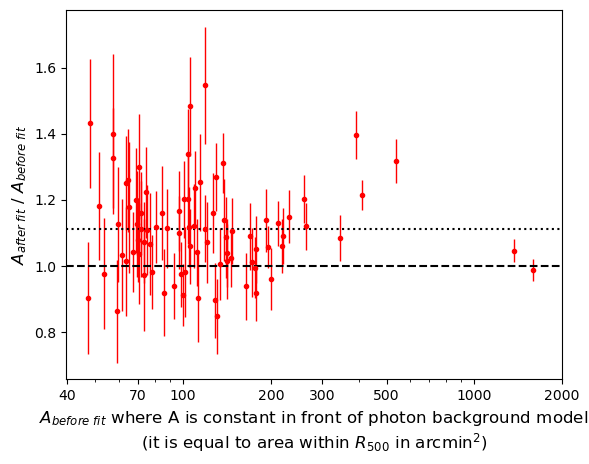

In [29]:
plt.errorbar(ORIGA, SKOLKO1, yerr=SKOLKO1_delta, elinewidth=1, color='red', markersize=3, marker='o', linewidth=0)
plt.xscale("log")
#plt.yscale("log")
plt.xlabel("$A_{before \\ fit}$ where A is constant in front of photon background model \n(it is equal to area within $R_{500}$ in arcmin$^2$)", fontsize=12)
plt.ylabel("$A_{after \\ fit} \\ / \\ A_{before \\ fit}$", fontsize=12)
xgtr = np.append(np.linspace(40, 100, 3).astype(int), [200,300,500, 1000, 2000])
plt.xticks(xgtr, xgtr)
#ygtr = [1,2,3,4,5,6,7]
#plt.yticks(ygtr, ygtr)
plt.axhline(1, ls='--', c='k')
plt.axhline(np.mean(SKOLKO1), ls=':', c='k')
plt.show()

### (G0) $T_{spec}$ with and without background

<Figure size 640x480 with 0 Axes>

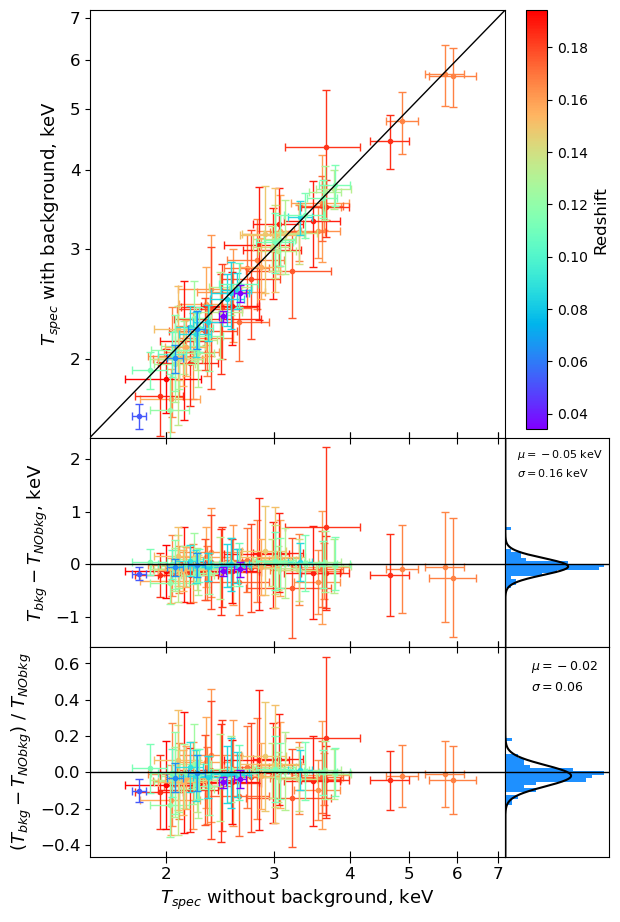

In [165]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

draw_three_panels_vertical(x_array=temp_usr, 
                  y_array=temp_usr_with_bkg,
                  x_label="$T_{spec}$ without background, keV",
                  y_label_left="$T_{spec}$ with background, keV",
                  y_label_right_up="$T_{bkg} - T_{NObkg}$, keV",
                  y_label_right_down="$(T_{bkg} - T_{NObkg}) \\ / \\ T_{NObkg}$",
                  clr='dodgerblue',
                  NnNn = NNNN,
                  cmap = redshifts,
                  cmap_label="Redshift")

#plt.savefig('figures/T_with_bkg_vs_T_without_bkg_vertical.pdf', format='pdf', bbox_inches='tight')
plt.show()

6496 (already), 7553 (new)

### (G1) Comparing clear $T$ and $L$ from fitting (not simulations) and them with background added:

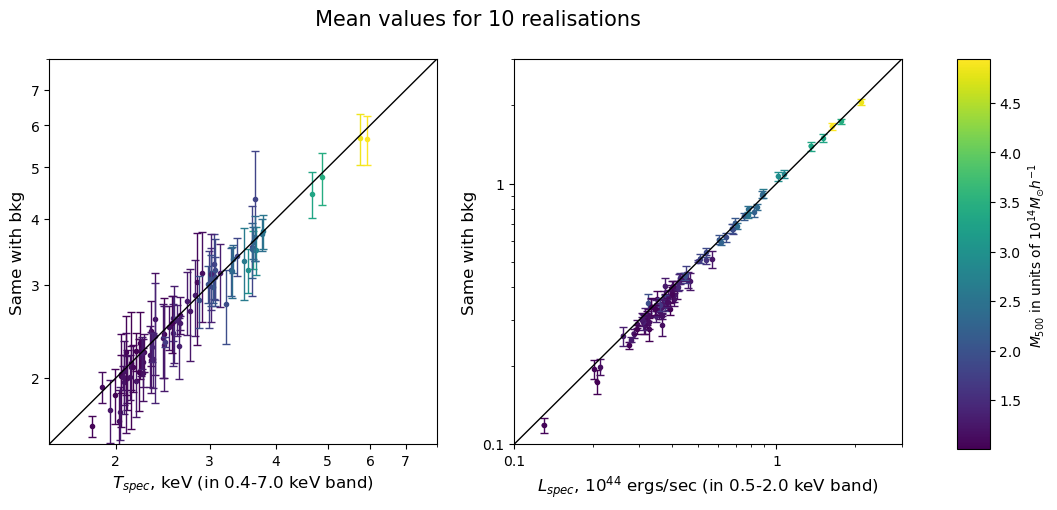

In [172]:
plt.figure(figsize=(11,5))

plt.suptitle(f"     Mean values for {NNNN} realisations", fontsize=15)

plt.subplot(121)

#xx = [a[0] for a in temp_usr_with_bkg]
xx = [a[1] for a in temp_usr]
yy = [a[1] for a in temp_usr_with_bkg]
y_err = [a[2] for a in temp_usr_with_bkg]

#plt.errorbar(xx, yy, yerr=[yerr_l, yerr_r], linewidth=0, elinewidth=1, color='b', marker='o', markersize=3)

for xxx, yyy, eee, col in zip(xx, yy, y_err, mass_colour):
    plt.plot(xxx, yyy, '.', color=col)
    plt.errorbar(xxx, yyy, yerr=eee, elinewidth=1, capsize=3, color=col)

#plt.xlabel("$T_{500}$, keV", fontsize=12)
plt.xlabel("$T_{spec}$, keV (in 0.4-7.0 keV band)", fontsize=12)
plt.ylabel("Same with bkg", fontsize=12)

plt.xlim(1.5, 8)
plt.ylim(1.5, 8)

plt.xscale("log")
plt.yscale("log")

plt.xticks([2,3,4,5,6,7], [2,3,4,5,6,7])
plt.yticks([2,3,4,5,6,7], [2,3,4,5,6,7])

plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim(), color='black', linewidth=1)


plt.subplot(122)

#xx = [a[0] for a in lumin_usr_with_bkg]
xx = [a[1] for a in lumin_usr]
yy = [a[1] for a in lumin_usr_with_bkg] #/(np.ones(len(redshifts))+redshifts)**2 # *np.sqrt(NORM)
y_err = [a[2] for a in lumin_usr_with_bkg] #/(np.ones(len(redshifts))+redshifts)**2 # *np.sqrt(NORM)

#plt.errorbar(xx, yy, yerr=[yerr_l, yerr_r], linewidth=0, elinewidth=1, color='b', marker='o', markersize=3)

for xxx, yyy, eee, col in zip(xx, yy, y_err, mass_colour):
    plt.plot(xxx, yyy, '.', color=col)
    plt.errorbar(xxx, yyy, yerr=eee, elinewidth=1, capsize=3, color=col)

#plt.xlabel("$L_{x500}$, $10^{44}$ ergs/sec", fontsize=12)
plt.xlabel("$L_{spec}$, $10^{44}$ ergs/sec (in 0.5-2.0 keV band)", fontsize=12)
plt.ylabel("Same with bkg", fontsize=12)

plt.xscale("log")
plt.yscale("log")

plt.xlim(0.1, 3)
plt.ylim(0.1, 3)

plt.xticks([0.1, 1], [0.1, 1])
plt.yticks([0.1, 1], [0.1, 1])

plt.plot( plt.gca().get_xlim(), plt.gca().get_ylim(), color='black', linewidth=1)

plt.subplots_adjust(right=0.9)
sc = plt.scatter(xx, yy, c=masses, s=5)
clb = plt.colorbar(sc, cax = plt.axes([0.95, 0.1, 0.03, 0.78]), 
                   label = "$M_{500}$ in units of $10^{14} M_{\\odot} h^{-1}$")

plt.savefig('figures/T_vs_T_and_L_vs_L_with_bkg.pdf', format='pdf')
plt.show()

### OBSOLETE

<Figure size 640x480 with 0 Axes>

Beta: [0.2312063  1.39231058]
Beta Std Error: [0.00800522 0.05075775]
Beta Covariance: [[ 2.63343267e-06 -1.36343605e-05]
 [-1.36343605e-05  1.05871685e-04]]
Residual Variance: 24.3346338344857
Inverse Condition #: 0.0865991090403901
Reason(s) for Halting:
  Sum of squares convergence
0.24083599553481647 0.1700689345921331


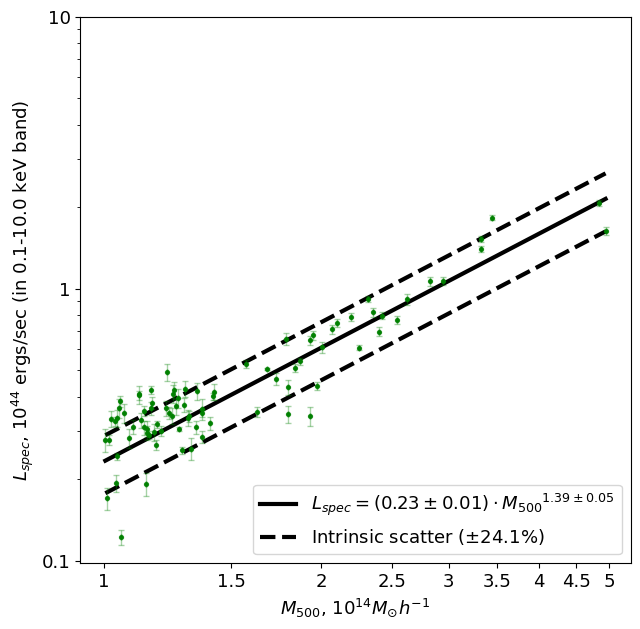

In [42]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

plt.figure(figsize=(7.1,7.1))

yyy = [a[1] for a in lumin_usr_with_bkg]
yyy_err = [a[2] for a in lumin_usr_with_bkg]

lll = np.linspace(min(masses), max(masses), 100)

draw_line(masses, np.array(masses)*0, yyy, yyy_err, 
          clr = 'green', 
          l4dots = 'Data from fit', 
          l4legend = 'L_{{spec}}',
          argument='M_{{500}}', 
          with_scatter=True)

plt.xlabel("$M_{500}$, $10^{14} M_{\\odot} h^{-1}$", fontsize=13)
plt.ylabel("$L_{spec}$, $10^{44}$ ergs/sec (in 0.1-10.0 keV band)", fontsize=13)

plt.xscale("log")
plt.yscale("log")

plt.xticks([1,1.5,2,2.5,3,3.5,4,4.5,5], [1,1.5,2,2.5,3,3.5,4,4.5,5], size=13)
plt.yticks([0.1, 1, 10], [0.1, 1, 10], size=13)

plt.legend(fontsize=13, loc=4)

plt.show()

### (G2) Average energy as a function of **mean** temperature with background added:

<Figure size 640x480 with 0 Axes>

Beta: [1.43389152 7.09377588]
Beta Std Error: [0.03961629 0.23414253]
Beta Covariance: [[ 0.00453815 -0.02513971]
 [-0.02513971  0.15852283]]
Residual Variance: 0.34583489196045075
Inverse Condition #: 0.05335325745077869
Reason(s) for Halting:
  Sum of squares convergence
0.09480193837643956 0.013040636387049876


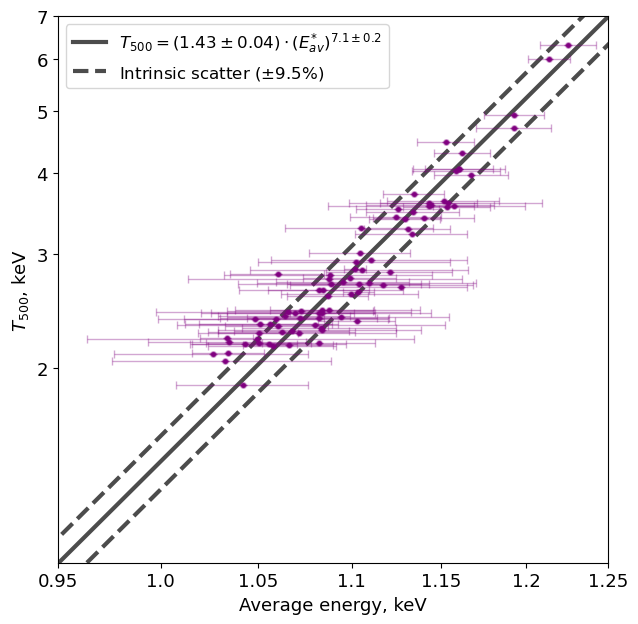

In [253]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

plt.figure(figsize=(7.1,7.1))

xx = [a[0] for a in aven_usr_with_bkg]
x_err = [a[1] for a in aven_usr_with_bkg]
yy1 = [a[0] for a in temp_usr_with_bkg]
yy2 = [a[1] for a in temp_usr_with_bkg]
y2_err = [a[2] for a in temp_usr_with_bkg]

lll = np.linspace(0.9, 1.5, 100)

#draw_line(xx, x_err, yy2, y_es=y2_err, 
#          clr = 'red', 
#          l4dots = '$T_{spec}$ from fit', 
#          l4legend = 'T_{{spec}}^{{BKG}}',
#          argument='E_{{av}}',
#          with_scatter=True)

draw_line(xx, x_err, yy1, y_es=np.array(yy1)*0, 
          clr = 'purple', 
          l4dots = '$T_{500}$ from simulations', 
          l4legend = 'T_{{500}}',
          argument='(E_{{av}}^{{*}})', 
          with_scatter=True)  

plt.xlabel("Average energy, keV", fontsize=13)
plt.ylabel("$T_{500}$, keV", fontsize=13)

plt.xscale("log")
plt.yscale("log")

Xtix = [0.95, 1.00, 1.05, 1.10, 1.15, 1.2, 1.25]
Ytix = [2,3,4,5,6,7]

plt.xticks(Xtix, Xtix, size=13)
plt.yticks(Ytix, Ytix, size=13)

plt.ylim(1, 7.)
plt.xlim(0.95, 1.25)

#for i in range(0, len(aven_usr)):
#    plt.plot([xx[i]+0.000454, xx[i]+0.000454], 
#             [yy1[i], yy2[i]], 
#             color='grey', alpha=0.5, marker='o', markersize=4)

plt.legend(loc=2, fontsize=12)

#plt.savefig('figures/T_vs_Eav_with_bkg-NEW.pdf', format='pdf', bbox_inches='tight')

plt.show()

### OBSOLETE

In [ ]:
plt.figure(figsize=(7, 5))
#plt.scatter(xx, yy1)
plt.xscale("log")
#plt.yscale("log")
plt.xticks([1.00, 1.05, 1.075, 1.10, 1.125, 1.15, 1.175, 1.2, 1.225, 1.25], 
           [1.00, 1.05, 1.075, 1.10, 1.125, 1.15, 1.175, 1.2, 1.225, 1.25], size=12)
plt.yticks(size=12)
#plt.scatter(xx234, yy234, label='no bkg')
#plt.scatter(xx, yy1-1.36*np.array(xx)**6.8, label='with bkg')
plt.legend(loc=3, fontsize=12)
plt.axhline(0, color='red', ls='--')
#for i in range(0, 84):
#    plt.arrow(xx[i], (yy1-1.36*np.array(xx)**6.8)[i], 
#              xx234[i]-xx[i], yy234[i]-(yy1-1.36*np.array(xx)**6.8)[i],length_includes_head=True,
#              head_width=0.003, head_length=0.03, fc='k', ec='k',
#              color='black', alpha=0.5)
plt.ylabel('$T_{spec}-T_{A.E.}$, keV', fontsize=12)
plt.xlabel("Average energy, keV", fontsize=12)
#plt.savefig('figures/T_spec-T_AE.pdf', format='pdf')
plt.show()

In [ ]:
%run -i 'utils/functions.py'

xx7 = [a[0] for a in aven_usr_with_bkg]
x_err7 = [a[1] for a in aven_usr_with_bkg]

def TfE(eav):
    return 1.29*np.array(eav)**7.1

temps7 = TfE(xx7)
lumins7 = np.zeros(84)
redshifts7 = zxs
temps6 = [a[0] for a in temp_usr]

x.Plot.device = "/xs"

for i in tqdm(range(84)):
    
    x.Xset.chatter = 0
    x.Model("apec", setPars={1:temps7[i], 2:0.3, 3:0, 4:1})
    x.Plot("model")
    
    x.AllData.clear()
    #fs = x.FakeitSettings(response = '../erosita/erosita_pirmf_v20210719.rmf', 
    #                           arf = '../erosita/tm1_arf_open_000101v02.fits', 
    #                    background = '', 
    #                      exposure = 10000, 
    #                    correction = '', 
    #                  backExposure = '', 
    #                      fileName = 'fakeit.pha')
    #x.AllData.fakeit(nSpectra = 1, 
    #                 settings = fs, 
    #               applyStats = True,
    #               filePrefix = "",
    #                  noWrite = False)
   
    x.AllModels.calcLumin(f"0.1 10.0 {redshifts7[i]}")
    L_bol = x.AllModels(1).lumin[0]

    x.AllModels.calcLumin(f"0.5 2.0 {redshifts7[i]}")
    L_05_20 = x.AllModels(1).lumin[0]
    
    x.Xset.chatter = 10
    
    lumin_bol = [a[1] for a in lumin_usr_with_bkg][i]
    
    lumins7[i] = L_05_20 #/L_bol*lumin_bol

In [ ]:
%run -i 'utils/functions.py'

fix = E(np.array(redshifts7))

plt.scatter(masses, clusters["Lx500"].values/fix)
plt.scatter(masses, lumins7/fix)
plt.xscale("log")
plt.yscale("log")
plt.show()

## (D) Luminosity vs. mass

With background!

<Figure size 640x480 with 0 Axes>

Beta: [2.95642748 0.77150523]
Beta Std Error: [0.08020352 0.03032897]
Beta Covariance: [[5.47584559e-04 1.67815588e-04]
 [1.67815588e-04 7.83032275e-05]]
Residual Variance: 11.747236220490482
Inverse Condition #: 0.1927761529914489
Reason(s) for Halting:
  Sum of squares convergence
0.18101091316107007 0.2513191093812197


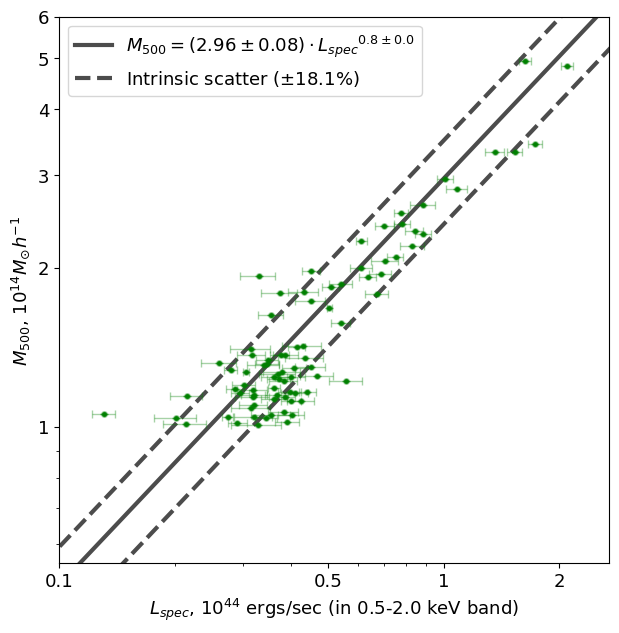

In [16]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'
%run -i 'utils/functions.py'

plt.figure(figsize=(7.1,7.1))

yyy = np.array([a[1] for a in lumin_usr])#/E(np.array(zxs))
yyy_err = np.array([a[2] for a in lumin_usr])#/E(np.array(zxs))

#yyy0520 = np.array([a[1] for a in lumin_usr0520])#/E(np.array(zxs))
#yyy_err0520 = np.array([a[2] for a in lumin_usr0520])/E(np.array(zxs))
#chastnoye = yyy/yyy0520
#chastnoye_err = chastnoye*(yyy_err/yyy + yyy_err0520/yyy0520)

lll = np.linspace(0.05, 3., 100)

draw_line(yyy, yyy_err, masses, np.array(masses)*0, 
          clr = 'green', 
          l4dots = '$L_{spec}$ from 50 realisations', 
          l4legend = 'M_{{500}}',
          argument = 'L_{spec}', 
          with_scatter=True)

#ae = rebin_scatterplot(yyy, masses, NBINS=15, cornerplot=False)

#plt.errorbar(ae[0], ae[2], xerr=ae[1], yerr=np.array(ae[2])*0, 
#             linewidth=0, marker='o', markersize=4, alpha=0.95,
#             elinewidth=2, capsize=3, color="r")                 

plt.ylabel("$M_{500}$, $10^{14} M_{\\odot} h^{-1}$", fontsize=13)
plt.xlabel("$L_{spec}$, $10^{44}$ ergs/sec (in 0.5-2.0 keV band)", fontsize=13)
#plt.ylabel("Factor = $L_{spec}$ (0.1-10.0 keV)  /  $L_{spec}$ (0.5-2.0 keV)", fontsize=13)

plt.xscale("log")
plt.yscale("log")

#plt.xticks([1,1.5,2,2.5,3,3.5,4,4.5,5], [1,1.5,2,2.5,3,3.5,4,4.5,5], size=13)
plt.yticks([1.0, 2, 3, 4, 5, 6, 7], [1, 2, 3, 4, 5, 6, 7], size=13)
plt.xticks([0.1, 0.5, 1, 2], [0.1, 0.5, 1, 2], size=13)
#plt.yticks([2, 3], [2, 3], size=13)
plt.legend(fontsize=13, loc=2)

#plt.gca().add_patch(Rectangle((0.07, 0.4), 0.15, 0.5, linewidth=1, 
#                              edgecolor='w', facecolor='w', fill=True, zorder=2))

plt.xlim(0.1, 2.7)
plt.ylim(0.55, 6)

#plt.scatter(masses, [a[0] for a in lumin_usr])
#plt.scatter(masses, 1.056 * 0.704**(-2) * (np.array(masses)/3.9)**1.61 * E(np.array(zxs))**(.85))

#plt.savefig('figures/L_vs_M_reversed.pdf', format='pdf')

plt.show()

## (H) Temperature vs. mass

At first: no background

<Figure size 640x480 with 0 Axes>

Beta: [0.31169799 1.6421555 ]
Beta Std Error: [0.03180361 0.10526788]
Beta Covariance: [[ 0.00340886 -0.01105636]
 [-0.01105636  0.03734631]]
Residual Variance: 0.29671807902741804
Inverse Condition #: 0.04855425784348748
Reason(s) for Halting:
  Sum of squares convergence
0.21566577813141002 0.20397643129452195


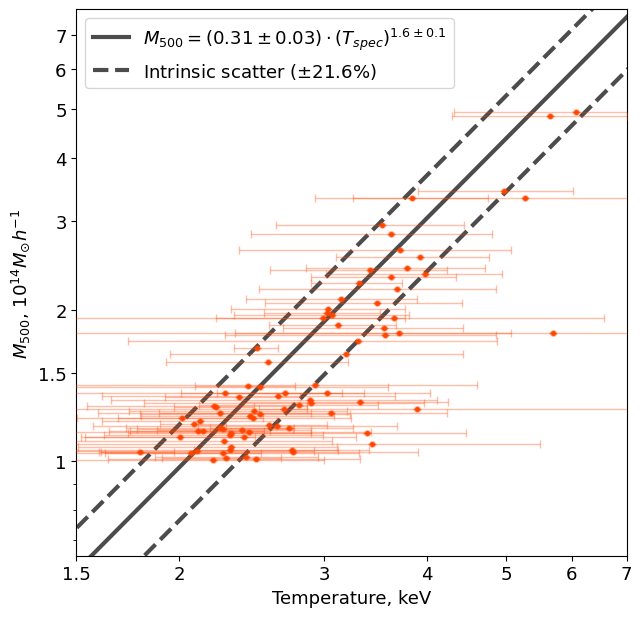

In [17]:
%run -i 'utils/functions.py'
%run -i 'utils/draw.py'

plt.figure(figsize=(7.1,7.1))

MASSES = [m/10**14 for m in clusters["M500"].values] # or just "masses" defined before
T500S = list(clusters["T500"].values)
yyyy1 = [a[1] for a in temp_usr]
yyyy1_err = [a[2] for a in temp_usr]
#yyyy2 = [a[1] for a in temp_usr_with_bkg]
#yyyy2_err = [a[2] for a in temp_usr_with_bkg]

#print(clusters["z_true"].values)

lll = np.linspace(1, 9, 100) #*E(clusters["z_true"].values)

#draw_line(MASSES, np.zeros(len(MASSES)), T500S, np.array(T500S)*0,
#          clr = 'black', 
#          l4dots = '$T_{500}$ from simulations', 
#          l4legend = 'T_{{500}}',
#          argument='M_{{500}}', 
#          with_scatter=True,
#          with_intervals=False)

#draw_line(yyyy1, yyyy1_err, MASSES, np.zeros(len(MASSES)), 
#          clr = 'black', 
#          l4dots = '$T_{spec}$ without background', 
#          l4legend = 'M_{{500}}',
#          argument = 'T_{{spec}}', 
#          with_scatter=True,
#          with_intervals=True)

draw_line(yyyy1, yyyy1_err, MASSES, np.zeros(len(MASSES)),
          clr = 'orangered', 
          l4dots = '$T_{spec}$ from 50 fits', 
          l4legend = 'M_{{500}}',
          argument = '(T_{{spec}})', 
          with_scatter=True,
          with_intervals=True)

plt.ylabel("$M_{500}$, $10^{14} M_{\\odot} h^{-1}$", fontsize=13)
plt.xlabel("Temperature, keV", fontsize=13)

plt.xscale("log")
plt.yscale("log")

#plt.xlim(1.4, 7.5)
plt.xlim(1.5, 8.9)

#plt.yticks([1,1.5,2,2.5,3,3.5,4,4.5,5], [1,1.5,2,2.5,3,3.5,4,4.5,5], size=13)
plt.yticks([1, 1.5, 2, 3, 4, 5, 6, 7], [1, 1.5, 2, 3, 4, 5, 6, 7], size=13)
plt.xticks([1.5,2,3,4,5,6,7, 8], [1.5,2,3,4,5,6,7, 8], size=13)

plt.legend(loc=2, fontsize=13)

#plt.gca().add_patch(Rectangle((1.5, 0.5), 1, 0.47, linewidth=1, 
#                              edgecolor='w', facecolor='w', fill=True, zorder=2))
plt.xlim(1.5, 7)
plt.ylim(0.65, 7.9)

#plt.savefig('figures/T_vs_M_no_bkg.pdf', format='pdf')

plt.show()

### Errors (on T) analysis

In [ ]:
delta_T_func_lowexp = (np.array(MASSES)/0.31)**(1/1.51)*0.3360073119152265
delta_T_single_lowexp = [a[2] for a in temp_usr_lowexp]

delta_T_func_2ksexp = (np.array(MASSES)/0.33)**(1/1.48)*0.2103481933193511
delta_T_single_2ksexp = [a[2] for a in temp_usr_2ksexp]

delta_T_func_midexp = (np.array(MASSES)/0.33)**(1/1.48)*0.15050116446327383
delta_T_single_midexp = [a[2] for a in temp_usr_midexp]

delta_T_func = (np.array(MASSES)/0.34)**(1/1.47)*0.14393018314614942
delta_T_single = [a[2] for a in temp_usr]

[-0.37664415 25.56233198]


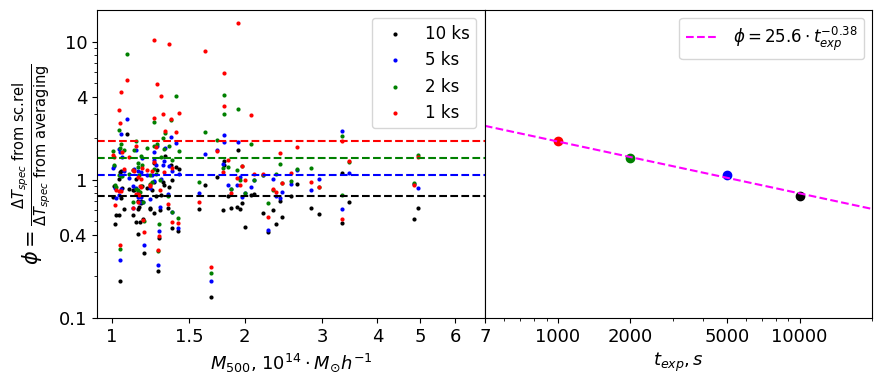

In [118]:
plt.figure(figsize=(10, 4))

plt.subplot(121)

plt.scatter(MASSES, delta_T_single/delta_T_func, 
             lw=0, color='black', marker=".", label='10 ks')

plt.scatter(MASSES, delta_T_single_midexp/delta_T_func_midexp, 
             lw=0, color='blue', marker=".", label='5 ks')

plt.scatter(MASSES, delta_T_single_2ksexp/delta_T_func_2ksexp, 
             lw=0, color='green', marker=".", label='2 ks')

plt.scatter(MASSES, delta_T_single_lowexp/delta_T_func_lowexp, 
             lw=0, color='red', marker=".", label='1 ks')

pop10ks = np.mean(delta_T_single/delta_T_func)
pop5ks = np.mean(delta_T_single_midexp/delta_T_func_midexp)
pop2ks = np.mean(delta_T_single_2ksexp/delta_T_func_2ksexp)
pop1ks = np.mean(delta_T_single_lowexp/delta_T_func_lowexp)

plt.axhline(pop10ks, color='black', ls='--')
plt.axhline(pop5ks, color='blue', ls='--')
plt.axhline(pop2ks, color='green', ls='--')
plt.axhline(pop1ks, color='red', ls='--')

plt.xlabel("$M_{500}$, $10^{14} \cdot M_{\odot} h^{-1}$", fontsize=13)
plt.ylabel("$\\phi = \\frac{\Delta T_{spec} \ \\text{from sc.rel}}{\Delta T_{spec} \ \\text{from averaging}}$", fontsize=15)
plt.legend(fontsize=12)
plt.xscale("log")
plt.yscale("log")
plt.xticks([1, 1.5, 2, 3, 4, 5, 6, 7], [1, 1.5, 2, 3, 4, 5, 6, 7], size=13)
plt.yticks([0.1, 0.4, 1, 4, 10], [0.1, 0.4, 1, 4, 10], size=13)
tyre = plt.gca().get_ylim()

plt.subplot(122)

#plt.scatter([1000, 2000, 5000, 10000], [pop1ks, pop2ks, pop5ks, pop10ks])
plt.scatter([1000], [pop1ks], color='red')
plt.scatter([2000], [pop2ks], color='green')
plt.scatter([5000], [pop5ks], color='blue')
plt.scatter([10000], [pop10ks], color='black')
plt.xscale("log")
plt.yscale("log")
plt.ylim(tyre)
plt.gca().set_yticks([], [])
plt.gca().yaxis.set_ticks_position('none')
plt.xlim(500, 20000)
plt.gca().set_xticks([1000, 2000, 5000, 10000], [1000, 2000, 5000, 10000], size=13)
plt.xlabel("$t_{exp}, s$", fontsize=13)

def sc(x, a, b):
    return b*x**a

popta, pcova = curve_fit(sc, [1000, 2000, 5000, 10000], [pop1ks, pop2ks, pop5ks, pop10ks], maxfev=10000)

print(popta)

xcxc = np.linspace(500, 20000, 100)

plt.plot(xcxc, sc(xcxc, *popta), linestyle='--', color = 'magenta', 
         label=f"$\phi = {{{popta[1]:.1f}}} \cdot t_{{exp}}^{{{popta[0]:.2f}}}$")

plt.legend(fontsize=12)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


### (H1) With background

<Figure size 640x480 with 0 Axes>

Beta: [0.37347443 1.57443977]
Beta Std Error: [0.03678433 0.10617312]
Beta Covariance: [[ 0.00063779 -0.00179535]
 [-0.00179535  0.00531353]]
Residual Variance: 2.121512624802355
Inverse Condition #: 0.06033350257279693
Reason(s) for Halting:
  Sum of squares convergence
0.21989541579450197 0.18446444820844993


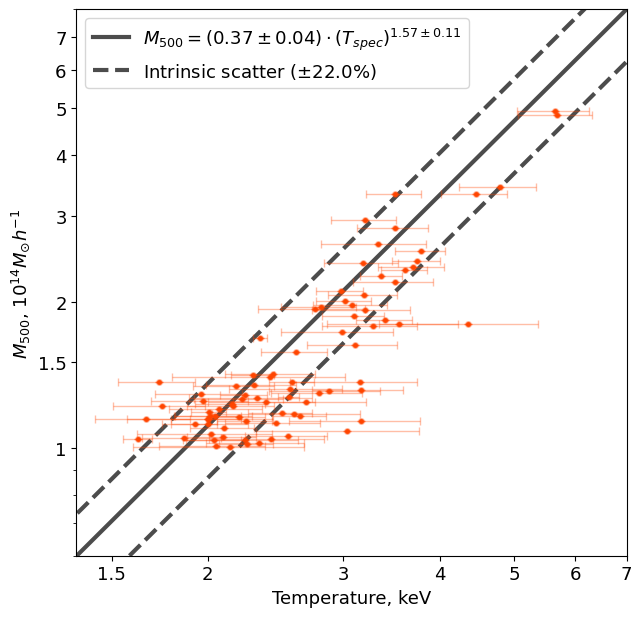

In [79]:
%run -i 'utils/functions.py'
%run -i 'utils/draw.py'

plt.figure(figsize=(7.1,7.1))

MASSES = [m/10**14 for m in clusters["M500"].values] # or just "masses" defined before
T500S = list(clusters["T500"].values)
yyyy1 = [a[1] for a in temp_usr]
yyyy1_err = [a[2] for a in temp_usr]
yyyy2 = [a[1] for a in temp_usr_with_bkg]
yyyy2_err = [a[2] for a in temp_usr_with_bkg]

#print(clusters["z_true"].values)

lll = np.linspace(1, 9, 100) #*E(clusters["z_true"].values)

#draw_line(MASSES, np.zeros(len(MASSES)), T500S, np.array(T500S)*0,
#          clr = 'black', 
#          l4dots = '$T_{500}$ from simulations', 
#          l4legend = 'T_{{500}}',
#          argument='M_{{500}}', 
#          with_scatter=True,
#          with_intervals=False)

#draw_line(yyyy1, yyyy1_err, MASSES, np.zeros(len(MASSES)), 
#          clr = 'black', 
#          l4dots = '$T_{spec}$ without background', 
#          l4legend = 'M_{{500}}',
#          argument = 'T_{{spec}}', 
#          with_scatter=True,
#          with_intervals=True)

draw_line(yyyy2, yyyy2_err, MASSES, np.zeros(len(MASSES)),
          clr = 'orangered', 
          l4dots = '$T_{spec}$ with background', 
          l4legend = 'M_{{500}}',
          argument = '(T_{{spec}})', 
          with_scatter=True,
          with_intervals=True)

plt.ylabel("$M_{500}$, $10^{14} M_{\\odot} h^{-1}$", fontsize=13)
plt.xlabel("Temperature, keV", fontsize=13)

plt.xscale("log")
plt.yscale("log")

#plt.xlim(1.4, 7.5)
plt.xlim(1.5, 8.9)

#plt.yticks([1,1.5,2,2.5,3,3.5,4,4.5,5], [1,1.5,2,2.5,3,3.5,4,4.5,5], size=13)
plt.yticks([1, 1.5, 2, 3, 4, 5, 6, 7], [1, 1.5, 2, 3, 4, 5, 6, 7], size=13)
plt.xticks([1.5,2,3,4,5,6,7, 8], [1.5,2,3,4,5,6,7, 8], size=13)

plt.legend(loc=2, fontsize=13)

#plt.gca().add_patch(Rectangle((1.5, 0.5), 1, 0.47, linewidth=1, 
#                              edgecolor='w', facecolor='w', fill=True, zorder=2))
plt.xlim(1.35, 7)
plt.ylim(0.6, 8.0)

#plt.savefig('figures/T_vs_M_with_bkg.pdf', format='pdf')

plt.show()

## (I) Average energy vs. mass

Assuming yes background

<Figure size 640x480 with 0 Axes>

Beta: [ 0.54742715 10.87728589]
Beta Std Error: [0.0345373  0.60251966]
Beta Covariance: [[ 0.00383174 -0.06301825]
 [-0.06301825  1.16617049]]
Residual Variance: 0.3113009096223133
Inverse Condition #: 0.01846275833186498
Reason(s) for Halting:
  Sum of squares convergence
0.2027746216662278 0.018550195462809314


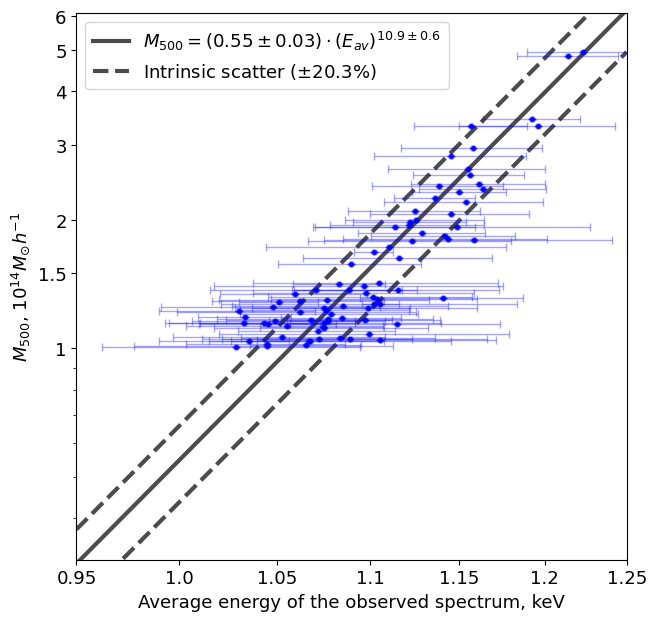

In [18]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

plt.figure(figsize=(7.1,7.1))

MASSES = [m/10**14 for m in clusters["M500"].values] # or just "masses" defined before

yyyy1 = [a[0] for a in aven_usr]
yyyy1_err = [a[1] for a in aven_usr]
#yyyy2 = [a[0] for a in aven_usr_with_bkg]
#yyyy2_err = [a[1] for a in aven_usr_with_bkg]

#lll = np.linspace(min(MASSES), max(MASSES), 100)
lll = np.linspace(0.95, 1.25, 100)
    
draw_line(yyyy1, yyyy1_err, MASSES, np.zeros(len(MASSES)),
          clr = 'blue', #'dodgerblue', 
          l4dots = '$E_{av}$ from 50 fits', 
          l4legend = 'M_{{500}}',
          argument = '(E_{{av}})',
          with_scatter=True)

#draw_line(yyyy2, yyyy2_err, MASSES, np.zeros(len(MASSES)), 
#          clr = 'orangered', 
#          l4dots = 'Data with background', 
#          l4legend = 'M_{{500}}',
#          argument = '(E_{{av}}^{{BKG}})',
#          with_scatter=True)    

plt.ylabel("$M_{500}$, $10^{14} M_{\\odot} h^{-1}$", fontsize=13)
plt.xlabel("Average energy of the observed spectrum, keV", fontsize=13)

plt.xscale("log")
plt.yscale("log")

plt.ylim(0.32, 6.1)
plt.xlim(0.95, 1.25)

plt.yticks([1,1.5,2,3,4,5,6], [1,1.5,2,3,4,5,6], size=13)
plt.xticks([0.95, 1.00, 1.05, 1.10, 1.15, 1.2, 1.25], [0.95, 1.00, 1.05, 1.10, 1.15, 1.2, 1.25], size=13)

#plt.gca().add_patch(Rectangle((1, 0.6), 0.1, 0.36, linewidth=1, 
#                              edgecolor='w', facecolor='w', fill=True, zorder=2))

plt.legend(loc=2, fontsize=13)

#plt.savefig('figures/Eav_vs_M.pdf', format='pdf')

plt.show()

### OBSOLETE

In [ ]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

calculate_scatter(MASSES, yyyy1, plot=True)
calculate_scatter(MASSES, yyyy2, plot=True)

### Errors (on E_av) analysis

In [126]:
delta_E_func_lowexp = (np.array(MASSES)/0.50)**(1/10.36)*0.0199615888422026
delta_E_single_lowexp = [a[1] for a in aven_usr_lowexp]

delta_E_func_2ksexp = (np.array(MASSES)/0.50)**(1/10.39)*0.02129632316993737
delta_E_single_2ksexp = [a[1] for a in aven_usr_2ksexp]

delta_E_func_midexp = (np.array(MASSES)/0.48)**(1/10.63)*0.01833050529287815
delta_E_single_midexp = [a[1] for a in aven_usr_midexp]

delta_E_func = (np.array(MASSES)/0.50)**(1/10.46)*0.018821425062671628
delta_E_single = [a[1] for a in aven_usr]

[-0.46789409 64.09683611]


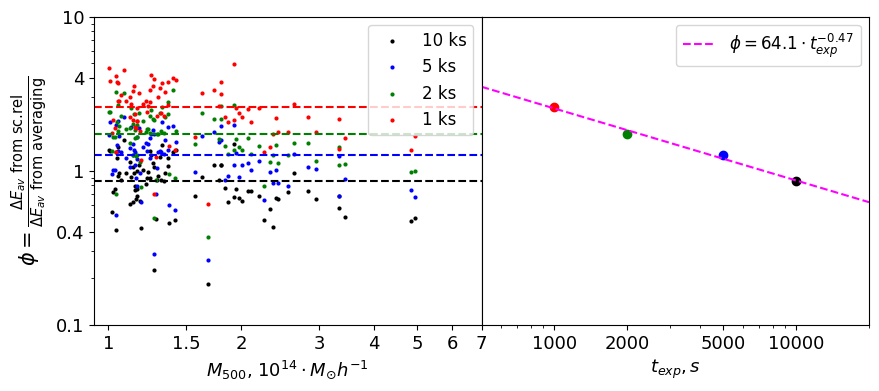

In [127]:
plt.figure(figsize=(10, 4))

plt.subplot(121)

plt.scatter(MASSES, delta_E_single/delta_E_func, 
             lw=0, color='black', marker=".", label='10 ks')

plt.scatter(MASSES, delta_E_single_midexp/delta_E_func_midexp, 
             lw=0, color='blue', marker=".", label='5 ks')

plt.scatter(MASSES, delta_E_single_2ksexp/delta_E_func_2ksexp, 
             lw=0, color='green', marker=".", label='2 ks')

plt.scatter(MASSES, delta_E_single_lowexp/delta_E_func_lowexp, 
             lw=0, color='red', marker=".", label='1 ks')

pop10ks = np.mean(delta_E_single/delta_E_func)
pop5ks = np.mean(delta_E_single_midexp/delta_E_func_midexp)
pop2ks = np.mean(delta_E_single_2ksexp/delta_E_func_2ksexp)
pop1ks = np.mean(delta_E_single_lowexp/delta_E_func_lowexp)

plt.axhline(pop10ks, color='black', ls='--')
plt.axhline(pop5ks, color='blue', ls='--')
plt.axhline(pop2ks, color='green', ls='--')
plt.axhline(pop1ks, color='red', ls='--')

plt.xlabel("$M_{500}$, $10^{14} \cdot M_{\odot} h^{-1}$", fontsize=13)
plt.ylabel("$\\phi = \\frac{\Delta E_{av} \ \\text{from sc.rel}}{\Delta E_{av} \ \\text{from averaging}}$", fontsize=15)
plt.legend(fontsize=12)
plt.xscale("log")
plt.yscale("log")
plt.xticks([1, 1.5, 2, 3, 4, 5, 6, 7], [1, 1.5, 2, 3, 4, 5, 6, 7], size=13)
plt.yticks([0.1, 0.4, 1, 4, 10], [0.1, 0.4, 1, 4, 10], size=13)
tyre = plt.gca().get_ylim()

plt.subplot(122)

#plt.scatter([1000, 2000, 5000, 10000], [pop1ks, pop2ks, pop5ks, pop10ks])
plt.scatter([1000], [pop1ks], color='red')
plt.scatter([2000], [pop2ks], color='green')
plt.scatter([5000], [pop5ks], color='blue')
plt.scatter([10000], [pop10ks], color='black')
plt.xscale("log")
plt.yscale("log")
plt.ylim(tyre)
plt.gca().set_yticks([], [])
plt.gca().yaxis.set_ticks_position('none')
plt.xlim(500, 20000)
plt.gca().set_xticks([1000, 2000, 5000, 10000], [1000, 2000, 5000, 10000], size=13)
plt.xlabel("$t_{exp}, s$", fontsize=13)

def sc(x, a, b):
    return b*x**a

popta, pcova = curve_fit(sc, [1000, 2000, 5000, 10000], [pop1ks, pop2ks, pop5ks, pop10ks], maxfev=10000)

print(popta)

xcxc = np.linspace(500, 20000, 100)

plt.plot(xcxc, sc(xcxc, *popta), linestyle='--', color = 'magenta', 
         label=f"$\phi = {{{popta[1]:.1f}}} \cdot t_{{exp}}^{{{popta[0]:.2f}}}$")

plt.legend(fontsize=12)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

## (J) How many realisations are enough?

https://en.wikipedia.org/wiki/Unbiased_estimation_of_standard_deviation

https://en.wikipedia.org/wiki/Bias_of_an_estimator

https://en.wikipedia.org/wiki/Bessel%27s_correction

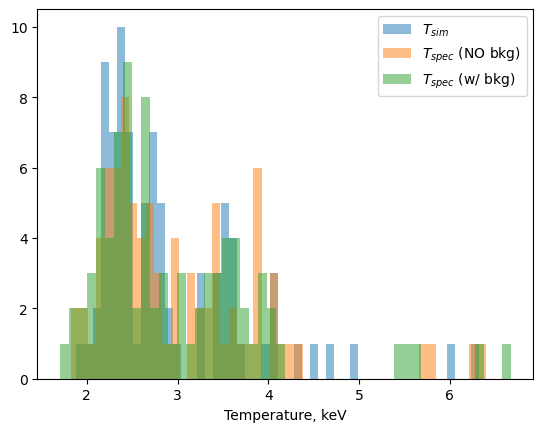

In [155]:
plt.hist([a[0] for a in temp_usr], bins=50, alpha=0.5, label="$T_{sim}$")
plt.hist([a[1] for a in temp_usr], bins=50, alpha=0.5, label="$T_{spec}$ (NO bkg)")
#plt.hist([a[0] for a in temp_usr_with_bkg], bins=20, alpha=0.5, label="$T_{sim}$")
plt.hist([a[1] for a in temp_usr_with_bkg], bins=50, alpha=0.5, label="$T_{spec}$ (w/ bkg)")
plt.xlabel("Temperature, keV")
plt.legend()
plt.show()

#### Lets check how the moments of our distribution depend on number of realisations:

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.


<Figure size 640x480 with 0 Axes>

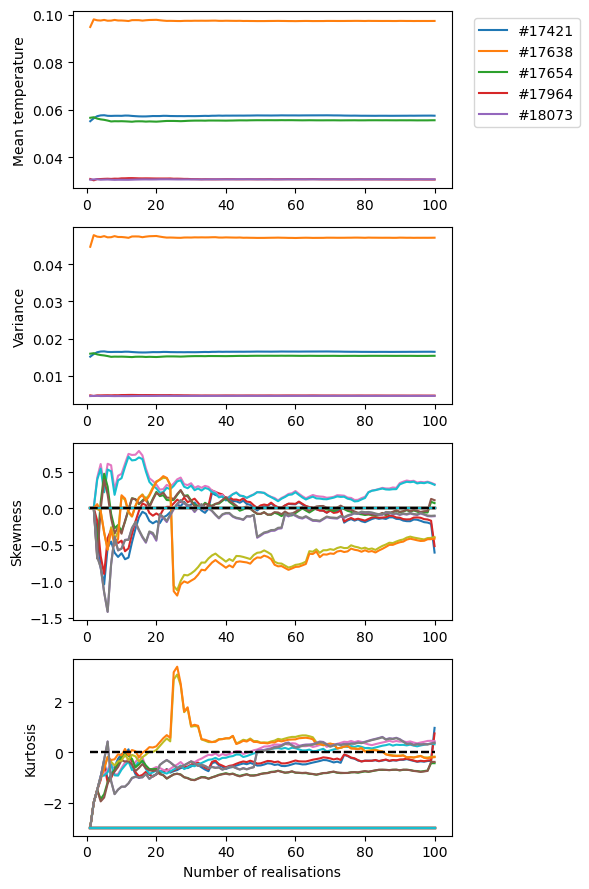

In [7]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6,9))

N_realisations = 100

#CL_NUMBER = clusters.index[:][-1]

for CL_NUMBER in tqdm(clusters.index[-10:-5]):

    cl_red = clusters.loc[CL_NUMBER]["z_true"]
    cl_T500 = clusters.loc[CL_NUMBER]["T500"]
    cl_lum = clusters.loc[CL_NUMBER]["Lx500"]

    temps = []      # увеличивающийся со временем массив со всеми температурами
    
    means = [] # массив со средними для данного набора
    variances = []    # массив со стандартными отклонениями для каждого отдельного набора температур
    skewnesses = []
    kurtosises = []
    
    for i in tqdm(range(1, N_realisations+1), leave=False):
        
        Ts = create_spectrum_and_fit_it(CL_NUMBER, borders=[0.4, 7.0], BACKGROUND=False, inside_radius=1,
                                    Xplot=False, plot=False)

        temps.append(Ts[1])
        #print(temps)

        mean = np.mean(temps)
        variance = np.var(temps)
        skewness = stats.skew(temps)
        kurtosis = stats.kurtosis(temps, fisher=True)
        #print(np.sum(temps)/i)    

        # If True, Fisher’s definition is used (normal ==> 0.0).
        # If False, Pearson’s definition is used (normal ==> 3.0).

        means.append(mean)
        variances.append(variance)
        skewnesses.append(skewness)
        kurtosises.append(kurtosis) #True
        
        #print(i, end="")
        
    plt.subplot(4,1,1)
    plt.plot(np.linspace(1,i,i), means, label='#'+str(CL_NUMBER))
    #plt.xlabel("Number of realisations")
    plt.ylabel("Mean temperature")
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    
    plt.subplot(4,1,2)
    plt.plot(np.linspace(1,i,i), variances, label='#'+str(CL_NUMBER))
    #plt.xlabel("Number of realisations")
    plt.ylabel("Variance")
    #plt.legend()
    
    plt.subplot(4,1,3)
    plt.plot(np.linspace(1,i,i), skewnesses, label='#'+str(CL_NUMBER))
    plt.plot(np.linspace(1,i,i), np.zeros(i), linestyle = '--', color='black') 
    #plt.xlabel("Number of realisations")
    plt.ylabel("Skewness")
    #plt.legend()
    
    plt.subplot(4,1,4)
    plt.plot(np.linspace(1,i,i), kurtosises, label='#'+str(CL_NUMBER))
    plt.plot(np.linspace(1,i,i), np.zeros(i), linestyle = '--', color='black')
    # [m**3+3*m*v for m, v in zip(means, variances)]
    plt.xlabel("Number of realisations")
    plt.ylabel("Kurtosis")
    #plt.legend()
    
    plt.subplots_adjust()
    plt.tight_layout()

    
plt.savefig("figures/check_if_norm_aven.pdf", format="pdf")
plt.show()

#### Pictures for histogram.gif

In [ ]:
%run -i 'utils/scripts.py'

N_realisations = 100

#CL_NUMBER = clusters.index[:][-1]

for CL_NUMBER in clusters.index[-5:-4]:

    cl_red = clusters.loc[CL_NUMBER]["z_true"]
    cl_T500 = clusters.loc[CL_NUMBER]["T500"]
    cl_lum = clusters.loc[CL_NUMBER]["Lx500"]

    temps = []      # увеличивающийся со временем массив со всеми температурами
    
    means = [] # массив со средними для данного набора
    variances = []    # массив со стандартными отклонениями для каждого отдельного набора температур
    skewnesses = []
    kurtosises = []
    
    Ts = create_spectrum_and_fit_it(CL_NUMBER, borders=[0.4, 7.0], BACKGROUND=False, inside_radius="R500",
                                    Xplot=False, plot=False, draw_only=False, draw_and_save_atable_model=False)

    temps.append(Ts[0][0])

    for i in range(2, N_realisations+1):
        
        Ts = create_spectrum_and_fit_it(CL_NUMBER, borders=[0.4, 7.0], BACKGROUND=False, inside_radius="R500",
                                    Xplot=False, plot=False, draw_only=False, draw_and_save_atable_model=False)

        temps.append(Ts[0][0])

        mean = np.mean(temps)
        stddev = np.std(temps)
        
        temps_norm = [(t-mean)/stddev for t in temps]
        
        plt.figure(figsize=(5,5))

        bars, bins = np.histogram(temps_norm)
        
        w = np.ones(len(temps_norm))#/len(temps_norm)
        
        plt.hist(temps_norm, weights = (1/np.sqrt(2*np.pi))*w/max(bars), color='#8c564b')
        
        xxxccc = np.linspace(-3,3,100)
        plt.plot(xxxccc, stats.norm.pdf(xxxccc), color='black', label="N(0,1)")
        
        plt.ylim(0, 0.44)
        
        plt.title("#"+str(CL_NUMBER)+": N="+str(i))
        plt.legend(loc="upper right")
        plt.xlabel("$(T_{spec} - T_{mean}) / \sigma$", fontsize=12)
    
        plt.savefig("../norm_dist/"+str(i)+".png", format="png")
        
        #plt.show()
        plt.clf()